## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 
from sklearn.metrics.pairwise import linear_kernel

## Importing the dataset

In [2]:
data=pd.read_csv("unofficialEmails.csv")

In [3]:
data.head()

,From,To,Subject,Body
0,phillip.allen@enron.com,buck.buckner@honeywell.com,Re: FW: fixed forward or other Collar floor ga...,"Mr. Buckner,\n\n For delivered gas behind San ..."
1,phillip.allen@enron.com,stagecoachmama@hotmail.com,NaN,"Lucy,\n\n Here are the rentrolls:\n\n\n\n Open..."
2,phillip.allen@enron.com,pallen70@hotmail.com,Westgate,---------------------- Forwarded by Phillip K ...
3,phillip.allen@enron.com,bs_stone@yahoo.com,NaN,"Brenda,\n\nPlease use the second check as the ..."
4,phillip.allen@enron.com,stouchstone@natsource.com,Re: Not business related..,I think Fletch has a good CPA. I am still doi...


In [71]:
data['Subject'].to_csv("EmailSubject.csv",index=False)

## Dataset information

- From = vendor's email over here
- To = employee's email over here

In [4]:
data.shape

(1836, 4)

## Checking the existence of missing values

In [5]:
data.isna().sum()

From         0
To           0
Subject    545
Body         0
dtype: int64

## Dropping the null values

In [6]:
data.dropna(inplace=True)

In [7]:
data.isna().sum()

From       0
To         0
Subject    0
Body       0
dtype: int64

In [8]:
data.shape

(1291, 4)

In [9]:
data.head(2)

,From,To,Subject,Body
0,phillip.allen@enron.com,buck.buckner@honeywell.com,Re: FW: fixed forward or other Collar floor ga...,"Mr. Buckner,\n\n For delivered gas behind San ..."
2,phillip.allen@enron.com,pallen70@hotmail.com,Westgate,---------------------- Forwarded by Phillip K ...


## Checking for duplicates 

In [10]:
data.duplicated().sum()

615

## Dropping the duplicates 

In [11]:
data.drop_duplicates(inplace=True)

In [12]:
data.duplicated().sum()

0

In [13]:
data.shape

(676, 4)

## How many unique vendor emails we have?

In [14]:
len(data['From'].unique())

68

## How many unique empolyees emails we have?

In [15]:
len(data['To'].unique())

250

## How many unique emails subjects we have?

In [16]:
len(data['Subject'].unique())

432

## How many unique emails Body we have?

In [17]:
len(data['Body'].unique())

584

## Some important functions

In [18]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'), 
        'to': map_to_list(emails, 'to'), 
        'from_': map_to_list(emails, 'from')
    }

def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [19]:
emails = pd.read_csv('emails.csv',nrows=5000)

emails.drop_duplicates(inplace=True)

In [20]:
# Lets create a new frame with the data we need.
email_df = pd.DataFrame(parse_into_emails(emails.message))

In [21]:
email_df.head(2)

,body,to,from_
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com


In [22]:
# Drop emails with empty body, to or from_ columns. 
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)

In [23]:
len(email_df.from_.unique())

494

In [24]:
len(email_df.to.unique())

838

In [25]:
email_df.shape

(4818, 3)

In [26]:
 #Some note on min_df and max_df
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"

In [27]:
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=list(stopwords), max_df=0.3, min_df=2)

In [28]:
X = vect.fit_transform(email_df.body)

In [29]:
features = vect.get_feature_names_out()

In [30]:
# Let's print the top 10 terms in document 1
top_feats_in_doc(X, features, 1, 10)

,features,score
0,meetings,0.389375
1,trip,0.324520
2,business,0.292258
3,ski,0.288418
4,takes,0.207473
5,try,0.152319
6,stimulate,0.147159
7,presenter,0.144209
8,productive,0.139399
9,flying,0.139399


In [31]:
# Now we print the top terms across all documents.
top_mean_feats(X, features, None, 0.1, 10)

,features,score
0,enron,0.045230
1,allen,0.010807
2,message,0.009672
3,email,0.009088
4,image,0.009082
5,gas,0.009073
6,john,0.008763
7,forwarded,0.007852
8,corp,0.007714
9,thanks,0.007208


In [32]:
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(X)

In [33]:
X_dense = np.array(X.todense())

In [34]:
pca = PCA(n_components=2).fit(X_dense)

In [35]:
coords = pca.transform(X_dense)

In [36]:
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]

In [37]:
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)

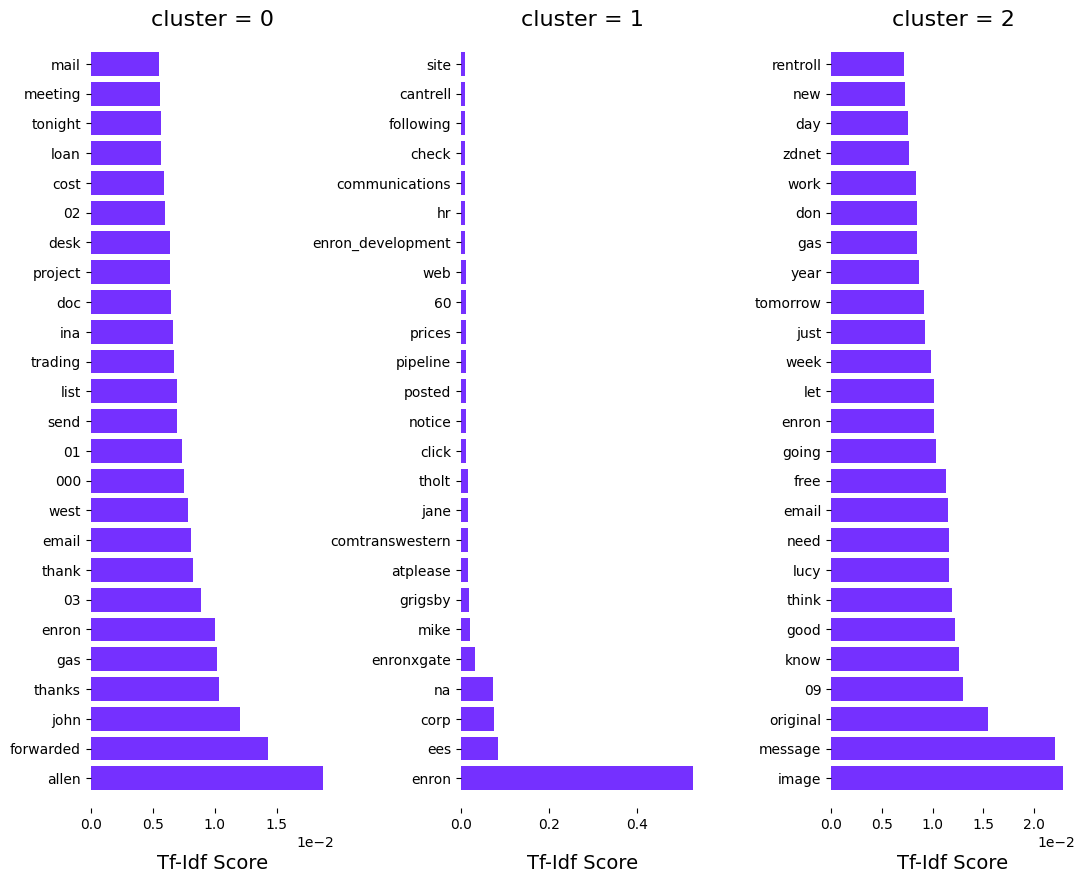

In [38]:
# Use this to print the top terms per cluster with matplotlib.
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

## Queries the dataset over here

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import linear_kernel


import pandas as pd



class EmailDataset: 
  def __init__(self):
    stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
    self.vec = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
    self.emails = read_email_bodies() 

    # train on the given email data.
    self.train()
  
  def train(self):
    self.vec_train = self.vec.fit_transform(self.emails)
  
  def query(self, keyword, limit):
    vec_keyword = self.vec.transform([keyword])
    cosine_sim = linear_kernel(vec_keyword, self.vec_train).flatten()
    related_email_indices = cosine_sim.argsort()[:-limit:-1]
    print(related_email_indices)
    return related_email_indices

  def find_email_by_index(self, i):
    return self.emails.as_matrix()[i]

In [40]:
emails = pd.read_csv('emails.csv',nrows=500) 
emails.duplicated().sum()

0

In [41]:
emails.drop_duplicates(inplace=True)

In [42]:
email_df = pd.DataFrame(parse_into_emails(emails.message))
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)

In [43]:
email_df

,body,to,from_
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com
5,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com
...,...,...,...
495,"Patti,This sounds like an opportunity to land ...","Chris Gaskill/Corp/Enron@Enron, Marc De La Roc...",phillip.allen@enron.com
496,I would support Matt Lenhart's promotion to th...,andrea.richards@enron.com,phillip.allen@enron.com
497,"Nick,There is a specific program that we are u...",nick.politis@enron.com,phillip.allen@enron.com
498,---------------------- Forwarded by Phillip K ...,All Enron Houston,phillip.allen@enron.com


In [44]:
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vec = TfidfVectorizer(analyzer='word', stop_words=list(stopwords), max_df=0.3, min_df=2)
vec_train = vec.fit_transform(email_df.body)

## Print out the vector of the first email

In [45]:
print(vec_train[0:1])

  (0, 1419)	1.0


## Find cosine similarity between the first email and all others.

In [46]:
cosine_sim = linear_kernel(vec_train[0:1], vec_train).flatten()

In [47]:
print(cosine_sim)

[1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

## Finding emails related to a query.

In [48]:
query = "business"

## Transform the query into the original vector

In [49]:
vec_query = vec.transform([query])

In [50]:
cosine_sim = linear_kernel(vec_query, vec_train).flatten()

## Find top 10 most related emails to the query.

In [51]:
related_email_indices = cosine_sim.argsort()[:-10:-1]
# print out the indices of the 10 most related emails.
print(related_email_indices)


[  1 277 140  52 132  60 182  56   7]


In [52]:
top10_related_emails = email_df.iloc[related_email_indices]

In [53]:
top10_related_emails

,body,to,from_
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com
286,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com
145,---------------------- Forwarded by Phillip K ...,Scott Neal/HOU/ECT@ECT,phillip.allen@enron.com
55,"Jeff,You would clearly receive a commission on...",jsmith@austintx.com,phillip.allen@enron.com
136,---------------------- Forwarded by Phillip K ...,Celeste Roberts/HOU/ECT@ECT,phillip.allen@enron.com
63,"jay.reitmeyer@enron.com, frank.ermis@enron.com...","John D Suarez/HOU/ECT@ECT, Suresh Vasan/Enron ...",phillip.allen@enron.com
190,"Laird,Did you meet with SWG on April 27th. Ar...",Jane M Tholt/HOU/ECT@ECT,phillip.allen@enron.com
59,---------------------- Forwarded by Phillip K ...,pallen@enron.com,phillip.allen@enron.com
9,---------------------- Forwarded by Phillip K ...,"""'Pallen@Enron.com'"" <Pallen@Enron.com>",phillip.allen@enron.com


In [54]:
# print out the first email 
first_email_index = related_email_indices[0]
print(email_df.body.to_numpy()[first_email_index])

Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.My suggestion for where to go is Austin.  Play golf and rent a ski boat and jet ski's.  Flying somewhere takes too much time.


In [55]:
# print out the second email 
second_email_index = related_email_indices[1]
print(email_df.body.to_numpy()[second_email_index])

Traveling to have a business meeting takes the fun out of the trip.Especially if you have to prepare a presentation.  I would suggest holdingthe business plan meetings here then take a trip without any formal businessmeetings.  I would even try and get some honest opinions on whether a trip iseven desired or necessary.As far as the business meetings, I think it would be more productive to tryand stimulate discussions across the different groups about what is workingand what is not.  Too often the presenter speaks and the others are quietjust waiting for their turn.   The meetings might be better if held in around table discussion format.My suggestion for where to go is Austin.  Play golf and rent a ski boat andjet ski's.  Flying somewhere takes too much time.


In [56]:
# print out the third email 
third_email_index = related_email_indices[2]
print(email_df.body.to_numpy()[third_email_index])

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 07/10/2000Scott NealVillarreal/HOU/ECT@ECT, Thomas A Martin/HOU/ECT@ECT---------------------------Jason MooreAttached please find a spreadsheet containing a list of natural gas customersin the Global Counterparty database.  These are all active counterparties,although we may not be doing any business with them currently.  If you haveany questions, please feel free to call me at x33198.Jason Moore


In [57]:
# print out the fourth email 
fourth_email_index = related_email_indices[3]
print(email_df.body.to_numpy()[fourth_email_index])

Jeff,You would clearly receive a commission on a deal on the sagewood.I am surprised by your request for payment on any type of project in whichI might become involved with Creekside.  Are you in the business of brokeringproperties or contacts?  Is your position based on a legal or what youperceive to be an ethical issue?  Did you propose we look at developing aproject from scratch?I am not prepared to pay more than 2.7 for sagewood yet.Phillip


In [58]:
# print out the fifth email 
fifth_email_index = related_email_indices[4]
print(email_df.body.to_numpy()[fifth_email_index])

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 07/12/2000Sorry, I didn't attach the form.  There is one for Associates and one forAnalyst.---------------------- Forwarded by Jana Giovannini/HOU/ECT on 07/11/2000Hey Phillip,I received your note from Celeste.  I am the ENA Staffing Coordinator andneed for you to fill out the attached Needs Assessment form before I can sendyou any resumes.  Also, would you be interested in the new class?  Analystsstart with the business units on Aug. 3rd and Assoc. start on Aug. 28th.  Weare starting to place the Associates and would like to see if you areinterested.  Please let me know.Once I receive the Needs Assessment back (and you let me know if you can waita month,) I will be happy to pull a couple of resumes for your review.  Ifyou have any questions, please let me know.  Thanks.---------------------- Forwarded by Jana Giovannini/HOU/ECT on 07/11/2000I believe Phillip Allen is from ENA.DoloresPM ---------------------------Celeste,I 

In [59]:
# print out the sixth email 
sixth_email_index = related_email_indices[5]
print(email_df.body.to_numpy()[sixth_email_index])

jay.reitmeyer@enron.com, frank.ermis@enron.com---------------------- Forwarded by Phillip K Allen/HOU/ECT on 09/06/2000Jeff RichterAM ---------------------------Crandall/PDX/ECT@ECT, Tim Belden/HOU/ECT@ECT, Jeff Richter/HOU/ECT@ECT, JohnM Forney/HOU/ECT@ECT, Matt Motley/PDX/ECT@ECT, Tom Alonso/PDX/ECT@ECT, MarkFischer/PDX/ECT@ECT---------------------------Enron Capital & Trade Resources Corp.Will/HOU/ECT@ECT, Doug Gilbert-Smith/Corp/Enron@ENRON, MikeSwerzbin/HOU/ECT@ECTDo not underestimate the effects of the Internet economy on load growth.  Ihave been preaching the tremendous growth described below for the last year.The utility infrastructure simply cannot handle these loads at thedistribution level and ultimatley distributed generation will be required forpower quality reasons.The City of Austin, TX has experienced 300+ MW of load growth this year dueto server farms and technology companies.  There is a 100 MW server farmtrying to hook up to HL&P as we speak and they cannot deliver f

In [60]:
# print out the seventh email 
seventh_email_index = related_email_indices[6]
print(email_df.body.to_numpy()[seventh_email_index])

Laird,Did you meet with SWG on April 27th.  Are there any other asset managementtargets in the west?---------------------- Forwarded by Phillip K Allen/HOU/ECT on 04/27/2000Jane M TholtAM ---------------------------Laird DyerJanie,Thanks for the fax on SW Gas.We are meeting with Larry Black, Bob Armstrong & Ed Zub on April 27th todiscuss asset management.  In preparation for that meeting we would like togain an understanding of the nature of our business relationship with SW.Could you, in general terms, describe our sales activities with SW.  What aretypical quantities and term on sales?  Are there any services we provide?How much pipeline capacity do we buy or sell to them?  Who are your maincontacts at SW Gas?We will propose to provide a full requirements supply to SW involving ourcontrol of their assets.  For this to be attractive to SW, we will probablyhave to take on their regulatory risk on gas purchase disallowance with thecommissions.  This will be difficult as there is no clea

In [61]:
# print out the eighth email 
eighth_email_index = related_email_indices[7]
print(email_df.body.to_numpy()[eighth_email_index])

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 09/06/2000Executive Impact & Influence Program* IMMEDIATE ACTION REQUIRED - Do Not Delete *As part of the Executive Impact and Influence Program, each participantis asked to gather input on the participant's own management styles andpractices as experienced by their immediate manager, each direct report,and up to eight peers/colleagues.You have been requested to provide feedback for a participant attendingthe next program.  Your input (i.e., a Self assessment, Manager assessment,Direct Report assessment, or Peer/Colleague assessment) will be combinedwith the input of others and used by the program participant to develop anaction plan to improve his/her management styles and practices.It is important that you complete this assessmentNO LATER THAN CLOSE OF BUSINESS Thursday, September 14.Since the feedback is such an important part of the program, the participantwill be asked to cancel his/her attendance if not enough feedbac

In [62]:
# print out the nineth email 
nineth_email_index = related_email_indices[8]
print(email_df.body.to_numpy()[nineth_email_index])

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/16/2000Phillip,> As discussed  during our phone conversation, In a Parallon 75 microturbine> power generation deal for a national accounts customer, I am developing a> proposal to sell power to customer at fixed or collar/floor price. To do> so I need a corresponding term gas price for same. Microturbine is an> onsite generation product developed by Honeywell to generate electricity> on customer site (degen). using natural gas. In doing so,  I need your> best fixed price forward gas price deal for 1, 3, 5, 7 and 10 years for> annual/seasonal supply to microturbines to generate fixed kWh for> customer. We have the opportunity to sell customer kWh 's using> microturbine or sell them turbines themselves. kWh deal must have limited/> no risk forward gas price to make deal work. Therein comes Sempra energy> gas trading, truly you.>> We are proposing installing 180 - 240 units across a large number of> stores (60-100) in San D

In [63]:
len(email_df['body'].unique())

480

## Performing text clustering with the help of BERT

In [64]:
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
from tqdm import tqdm

## for processing
import re
import nltk

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for w2v
import gensim
import gensim.downloader as gensim_api

## for BERT
import transformers
import os

In [65]:
import tensorflow as tf


In [66]:
print(tf.__version__)

2.12.1


In [67]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda()) 

[]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False
False


In [68]:
dtf = email_df
dtf.head()

,body,to,from_
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com
5,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com


In [72]:
data.shape

(676, 4)

In [69]:
dtf['body'].to_csv("EmailsBody.csv",index=False)

In [179]:
print(f'the dataset contains {len(dtf)} news articles')

the dataset contains 490 news articles


In [180]:
print(f'there are {len(set(dtf.to))} categories in the to feature')
print(set(dtf.to))

there are 212 categories in the to feature
{'christopher.calger@enron.com', 'julie.gomez@enron.com', 'patti99@hotmail.com', 'John J Lavorato/Corp/Enron@Enron, Phillip K Allen/HOU/ECT@ECT, Scott', 'robert.badeer@enron.com', 'Phillip K Allen/HOU/ECT@ECT, Thomas A Martin/HOU/ECT@ECT, Scott', 'Julie A Gomez/HOU/ECT@ECT, Stephanie Miller/Corp/Enron@ENRON, Chris', 'mark.scott@enron.com', 'Jim Fallon/HOU/ECT@ECT, Phillip K Allen/HOU/ECT@ECT', 'andrew_m_ozuna@mail.bankone.com', 'sunil.dalal@enron.com', 'Phillip K Allen/HOU/ECT@ECT, John Arnold/HOU/ECT@ECT', 'jim123@pdq.net', 'matthew.lenhart@enron.com', 'Alan Comnes/PDX/ECT@ECT, Angela Schwarz/HOU/EES@EES, Beverly', 'barry.tycholiz@enron.com', 'phillip.k.allen@enron.com', 'Lloyd Fleming/LON/ECT@ECT, Andreas Barschkis/EU/Enron@Enron, Michael', 'Chris Gaskill/Corp/Enron@Enron, Marc De La Roche/HOU/ECT@ECT, Mark A', 'brenda.flores-cuellar@enron.com', '"Keith Holst" <kholst@enron.com>, "Phillip Allen" <pallen@enron.com>', 'randall.gay@enron.com', 

In [181]:
print(f'there are {len(set(dtf.from_))} categories in the from feature')
print(set(dtf.from_))

there are 16 categories in the from feature
{'Hayden, Frank =20', 'Frank Hayden/ENRON@enronXgate on 04/24/2001 09', 'Phillip.K.Allen@enron.com [mailto', 'Sarah Novosel@ENRON on 12/13/2000 10', 'Andy Chen on 07/12/2000 02', 'Mark Whitt@ENRON on 02/08/2001 03', 'pallen@enron.com [mailto', 'Kristin Walsh/ENRON@enronXgate on 05/04/2001 04', 'Allen, Phillip', 'James D Steffes@ENRON on 02/21/2001 12', 'Phillip.K.Allen@enron.com', 'Leslie Lawner@ENRON on 12/12/2000 11', 'Mark Whitt@ENRON on 02/09/2001 03', 'Phillip K Allen [mailto', 'phillip.allen@enron.com', 'ina.rangel@enron.com'}


## Observations

- We have lesser number of vendor emails and more number of employees emails over here in the dataset

In [182]:
dtf = dtf.rename(columns={"from_":"from","body":"text"})
## print 5 random rows
dtf.sample(5)

,text,to,from
144,---------------------- Forwarded by Phillip K ...,"Jeffrey A Shankman/HOU/ECT@ECT, Hunter S Shive...",phillip.allen@enron.com
176,"Al,I was glad to hear from you. I hope we can...",al.pollard@enron.com,phillip.allen@enron.com
73,John Lavorato-MMike Grigsby-DKeith Holst-DFran...,debe@fsddatasvc.com,phillip.allen@enron.com
368,"Steve,Try bmckay@enron.com or Brad.McKay@enron...",stouchstone@natsource.com,phillip.allen@enron.com
127,the merlin ct. address is still good. I don't...,mac.d.hargrove@rssmb.com,phillip.allen@enron.com


## Text preprocessing
- remove punctuation, convert to lower case
- tokenize text to words
- remove stopwords (nltk)
- Stemming and lemmatisation

In [183]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    '''
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    '''

    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [184]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\revoquant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [185]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [186]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\revoquant\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [187]:
dtf["text_clean"] = dtf["text"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
dtf.head()

,text,to,from,text_clean
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com,forecast
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com,traveling business meeting take fun trip espec...
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com,test successful way go
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com,randycan send schedule salary level everyone t...
5,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com,greghow either next tuesday thursdayphillip


In [188]:
dtf['text_clean'].to_csv("words.csv",index=False)

## Creating the target clusters over here

Loading gensim GloVe word embeddings

In [189]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

## The gensim package has a very convenient function that returns the most similar words for any given word into the vocabulary


In [190]:
nlp.most_similar(["fraud"], topn=3)

[('fraudulent', 0.6845650672912598),
 ('embezzlement', 0.6509636044502258),
 ('evasion', 0.6368284821510315)]

In [191]:
nlp.most_similar(["vendor"], topn=3)

[('vendors', 0.6983526945114136),
 ('kiosk', 0.528968095779419),
 ('seller', 0.5135998129844666)]

In [192]:
nlp.most_similar(["emails"], topn=3)

[('e-mails', 0.8391492366790771),
 ('mails', 0.7864304184913635),
 ('e-mail', 0.7012836933135986)]

In [193]:
nlp.most_similar(["employees"], topn=3)

[('workers', 0.7581698298454285),
 ('employee', 0.7226613163948059),
 ('jobs', 0.6323162317276001)]

In [194]:
nlp.most_similar(["planning"], topn=3)

[('planned', 0.6849149465560913),
 ('plans', 0.6689828634262085),
 ('preparing', 0.6209443807601929)]

In [195]:
nlp.most_similar(["forecast"], topn=3)

[('forecasts', 0.8918458223342896),
 ('predicted', 0.7120217680931091),
 ('forecasting', 0.6862271428108215)]

In [196]:
nlp.most_similar(["procurement"], topn=3)

[('logistics', 0.48259109258651733),
 ('procurements', 0.47741827368736267),
 ('contracting', 0.460159033536911)]

In [197]:
nlp.most_similar(["report"], topn=3)

[('reports', 0.7629156112670898),
 ('reported', 0.6687825322151184),
 ('according', 0.6409565210342407)]

In [198]:
nlp.most_similar(["databases"], topn=3)

[('database', 0.81102454662323),
 ('searchable', 0.5670948028564453),
 ('computerized', 0.5647352337837219)]

In [199]:
nlp.most_similar(["system"], topn=3)

[('systems', 0.7945240139961243),
 ('which', 0.5137308835983276),
 ('mechanism', 0.5113971829414368)]

In [200]:
nlp.most_similar(["business"], topn=3)

[('businesses', 0.7113703489303589),
 ('industry', 0.6664634943008423),
 ('companies', 0.6210777759552002)]

In [201]:
nlp.most_similar(["revenue"], topn=3)

[('revenues', 0.8885501027107239),
 ('profits', 0.6783910989761353),
 ('earnings', 0.660737931728363)]

In [202]:
nlp.most_similar(["csv"], topn=3)

[('lsap', 0.4368089437484741),
 ('rtf', 0.42949891090393066),
 ('comma-separated', 0.41335994005203247)]

In [203]:
nlp.most_similar(["legacy"], topn=3)

[('legacies', 0.6002347469329834),
 ('enduring', 0.5070117115974426),
 ('generations', 0.5037804245948792)]

In [204]:
nlp.most_similar(["learning"], topn=3)

[('learn', 0.6861351728439331),
 ('teaching', 0.6573554277420044),
 ('skills', 0.6242095828056335)]

In [205]:
nlp.most_similar(["fake"], topn=3)

[('phony', 0.692793607711792),
 ('bogus', 0.6607178449630737),
 ('counterfeit', 0.645099401473999)]

In [206]:
nlp.most_similar(["sales"], topn=3)

[('retail', 0.6513686776161194),
 ('revenue', 0.6269890069961548),
 ('profits', 0.6251612305641174)]

In [207]:
nlp.most_similar(["anomaly"], topn=3)

[('anomalies', 0.6353979110717773),
 ('anomalous', 0.5019755959510803),
 ('oddity', 0.4975854754447937)]

In [208]:
nlp.most_similar(["visualization"], topn=3)

[('visualisation', 0.6390158534049988),
 ('visualizations', 0.5735960602760315),
 ('real-time', 0.5709123611450195)]

In [209]:
nlp.most_similar(["wrong"], topn=3)

[('think', 0.6920519471168518),
 ('know', 0.6591437458992004),
 ('something', 0.650749683380127)]

## Now we are going to apply the above function on our custom dataset

In [210]:
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

## Over here we are defining the clusters

In [211]:
## Create Dictionary {category:[keywords]}
dic_clusters = {}
dic_clusters["Fraud"] = get_similar_words(['deception','scam','swindle',"cheat","trickery","imposture","sham","deceit","fakery"], top=30, nlp=nlp)
dic_clusters["Vendor"] = get_similar_words(['seller', 'merchant', 'supplier', 'retailer', 'dealer', 'trader', 'salesperson', 'peddler', 'pedlar', 'shopkeeper', 'distributor', 'wholesaler', 'businessperson', 'hawker', 'salesman','saleswoman', 'trader', 'seller', 'purveyor', 'marketer', 'entrepreneur'], top=30, nlp=nlp)
dic_clusters["Employee"] = get_similar_words(['workers', 'staff', 'members', 'personnel', 'workforce', 'laborers', 'associates', 'colleagues', 'crew', 'executives', 'team', 'workers', 'co-workers', 'jobholders', 'workmates', 'employed', 'workmen'], top=30, nlp=nlp)



In [212]:

## print top 5 closest words
print('Top words per label:')

for k,v in dic_clusters.items():
    print("{0:15}..... {1}".format(k, v[0:5], len(v)))

Top words per label:
Fraud          ..... ['obfuscation', 'deceptions', 'blatant', 'blackmail', 'evasion']
Vendor         ..... ['buys', 'banker', 'broker', 'auctioneer', 'shopper']
Employee       ..... ['employ', 'engineers', 'employers', 'co-workers', 'employed']


## Visualize the selected topics with keyword clusters

<IPython.core.display.Javascript object>


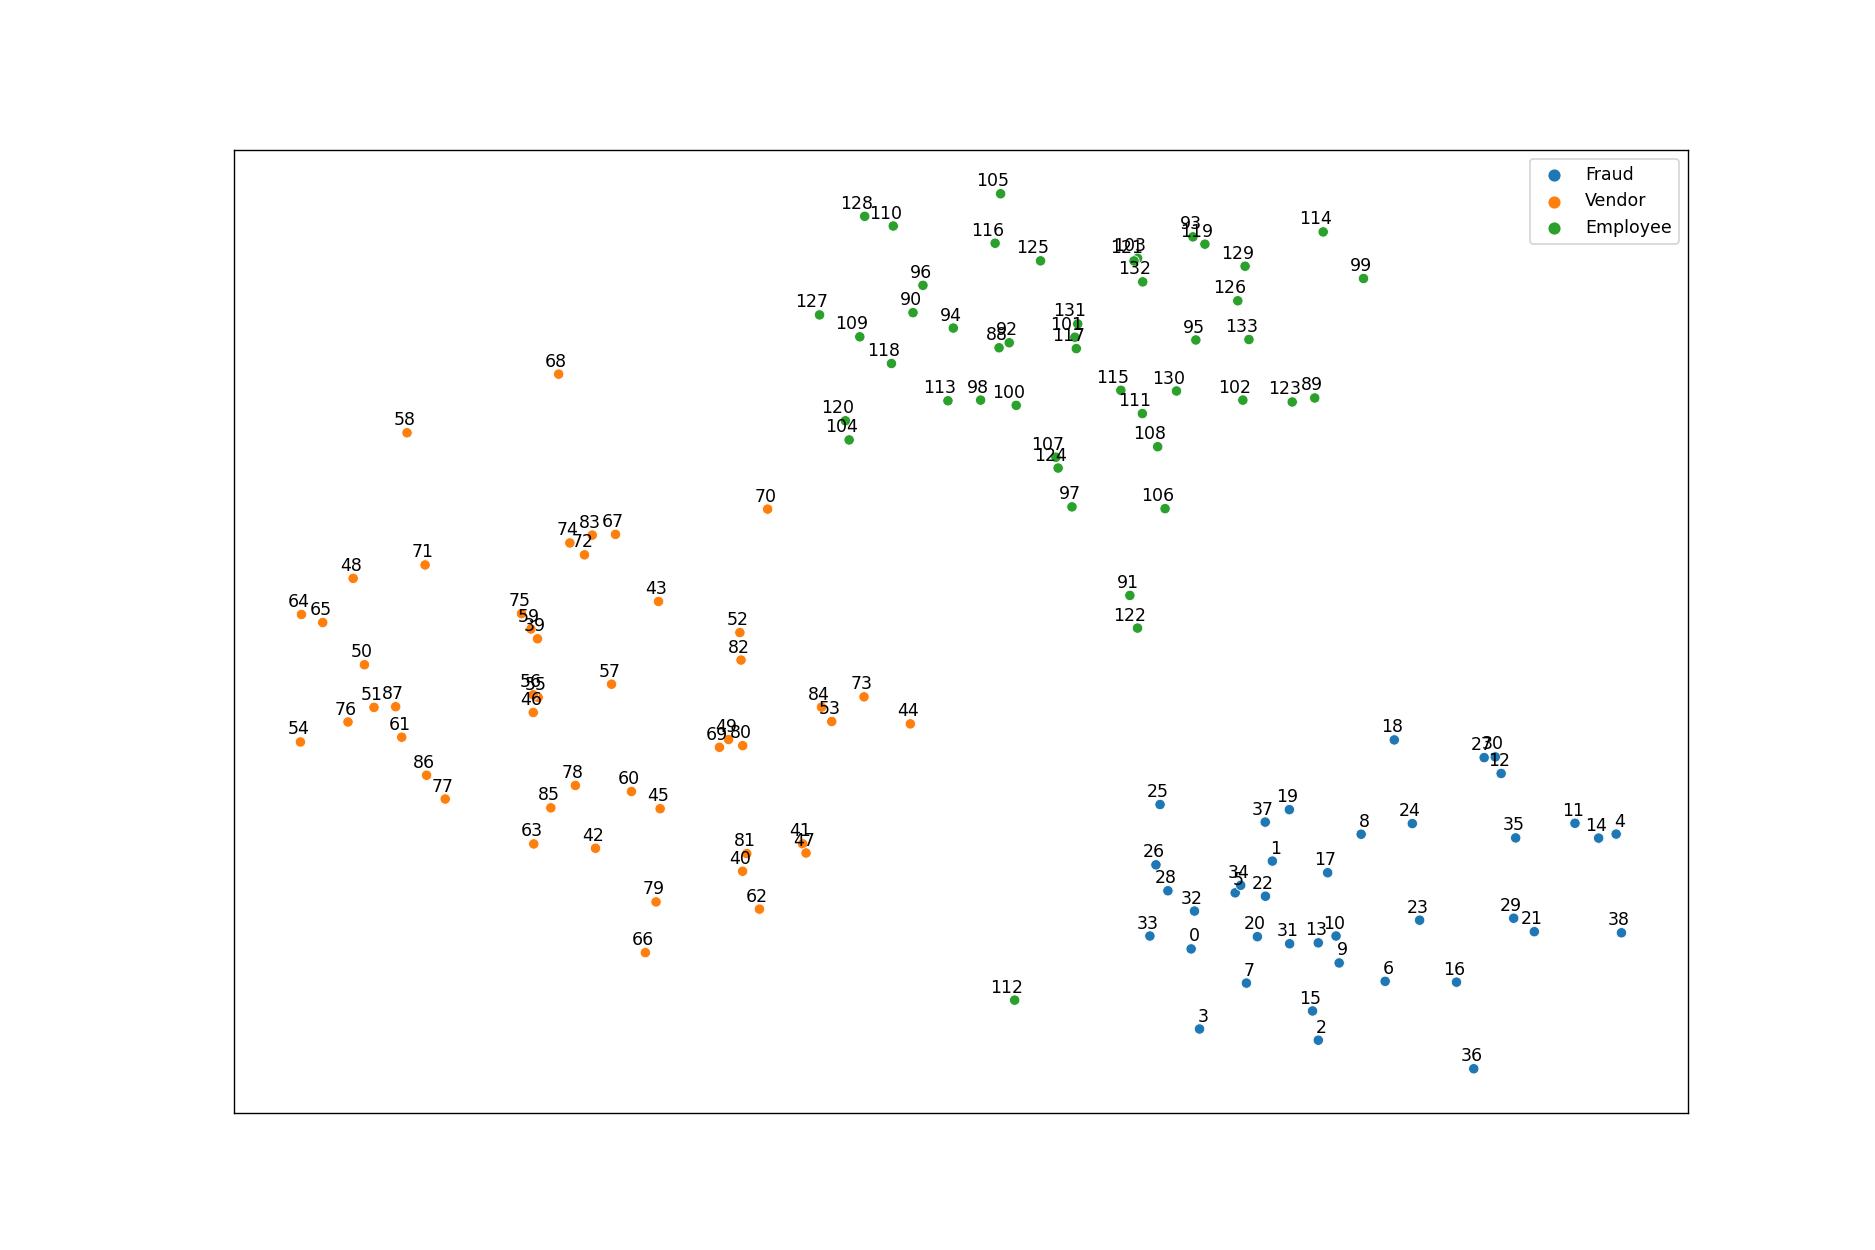

In [213]:
## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_GloVe = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf_GloVe) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf_GloVe):size], columns=["x","y"], index=v)
    dtf_group["cluster"] = k
#     dtf_GloVe = dtf_GloVe.append(dtf_group)
    dtf_GloVe = pd.concat([dtf_GloVe,dtf_group],ignore_index=True)
        
## plot
%matplotlib notebook
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=dtf_GloVe, x="x", y="y", hue="cluster", ax=ax)
ax.legend().texts[0].set_text(None)
ax.legend()
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
for i in range(len(dtf_GloVe)):
    ax.annotate(dtf_GloVe.index[i], xy=(dtf_GloVe["x"].iloc[i], dtf_GloVe["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

## Text Clustering using the BERT model over here

In [214]:

## for BERT
import transformers
## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-large-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [215]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\revoquant\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [216]:
X.shape

(134, 2)

## We can do the filtering of the words that are not required to solve our specific use case over here

In [217]:
import numpy as np

def utils_bert_embedding(txt, tokenizer, nlp):
    '''
    Word embedding with Bert (equivalent to nlp["word"]).
    :parameter?
        :param txt: string 
        :param tokenizer: transformers tokenizer
        :param nlp: transformers bert
    :return
        tensor sentences x words x vector (1x3x768) 
    '''
    # Truncate the input text to the first 10 words
    
    
    truncated_txt = " ".join(txt[0:200])
    print(txt[0:200])

    # Tokenize sentence to tokens (integers)
    idx = tokenizer.encode(truncated_txt)

    # Convert to array of shape (1, num_words+2) - EOS and CLS added
    idx = np.array(idx)[None, :]

    # Generate embeddings for each token - output is a tuple
    embedding = nlp(idx)

    # Select first member of the tuple, remove first dimension which is 1 to get (num_words, embedding size 768)
    # Exclude CLS and EOS tokens
    X = np.array(embedding[0][0][1:-1])
   
    return X

In [218]:
import time
from tqdm import tqdm

## create list of news vector using list comprehension and measure the execution time
start_time = time.time()
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in tqdm(dtf["text_clean"])]
end_time = time.time()

print(f"Execution time: {end_time - start_time:.2f} seconds")

  0%|                                                                                          | 0/490 [00:00<?, ?it/s]

forecast


  0%|▏                                                                                 | 1/490 [00:00<02:52,  2.83it/s]

traveling business meeting take fun trip especially prepare presentation would suggest holding business plan meeting take trip without formal business meeting would even try get honest opinion whether


  0%|▎                                                                                 | 2/490 [00:01<05:46,  1.41it/s]

test successful way go


  1%|▌                                                                                 | 3/490 [00:01<04:28,  1.81it/s]

randycan send schedule salary level everyone thescheduling group plus thought change need madepatti examplephillip


  1%|▋                                                                                 | 4/490 [00:02<05:09,  1.57it/s]

greghow either next tuesday thursdayphillip


  1%|▊                                                                                 | 5/490 [00:02<04:53,  1.65it/s]

phillip allen pallenenroncommike grigsby mikegrigsbyenroncomkeith holst kholstenroncommonique sanchezfrank ermisjohn lavoratothank helpphillip allen


  1%|█                                                                                 | 6/490 [00:04<06:14,  1.29it/s]

dont think required isp2 static ip address


  1%|█▏                                                                                | 7/490 [00:04<05:54,  1.36it/s]

forwarded phillip k allenhouect 10162000phillip discussed phone conversation parallon 75 microturbine power generation deal national account customer developing proposal sell power customer fixed coll


  2%|█▎                                                                                | 8/490 [00:06<07:15,  1.11it/s]

mr bucknerfor delivered gas behind san diego enron energy service appropriateenron entity forwarded request zarin imam ee phonenumber 7138537107phillip allen


  2%|█▌                                                                                | 9/490 [00:07<07:46,  1.03it/s]

lucyopen save rentroll folder follow step dontmisplace files1 click save as4 click appropriate folderphillip


  2%|█▋                                                                               | 10/490 [00:07<07:24,  1.08it/s]

forwarded phillip k allenhouect 10092000richard burchfieldphillipbelow issue list go forward documenting therequirements consolidated physicalfinancial position transporttrade capture need focus first


  2%|█▊                                                                               | 11/490 [00:09<08:10,  1.02s/it]

forwarded phillip k allenhouect 10092000richard burchfieldphillipbelow issue list go forward documenting therequirements consolidated physicalfinancial position transporttrade capture need focus first


  2%|█▉                                                                               | 12/490 [00:10<08:31,  1.07s/it]

davehere name west desk member category originationside sparsephillip


  3%|██▏                                                                              | 13/490 [00:11<07:38,  1.04it/s]

paula35 million finephillip


  3%|██▎                                                                              | 14/490 [00:11<06:44,  1.18it/s]

forwarded phillip k allenhouect 10042000enron north america corpnealhouectect john arnoldhouectect grant massonhouectect tedmurphyhouectect vladimir gornyhouectect frank haydencorpenronenronhardercorp


  3%|██▍                                                                              | 15/490 [00:12<07:32,  1.05it/s]

timmike grigsby problem accessing west power site please make sure active passwordthank youphillip


  3%|██▋                                                                              | 16/490 [00:13<07:14,  1.09it/s]

forwarded phillip k allenhouect 10032000please respond cbpresaustinrrcomwestgateenclosed demographic westgate site investor allianceinvestors alliance say demographic similar packageon san marcos rece


  3%|██▊                                                                              | 17/490 [00:14<07:43,  1.02it/s]

forwarded phillip k allenhouect 10032000nancy hallenronluccinaenronenron paul bieniawskicorpenronenron tyrellharrisonnaenronenronjacksoncorpenronenronstorage strategy west please mark calendarsthank y


  4%|██▉                                                                              | 18/490 [00:16<08:14,  1.05s/it]

brendaplease use second check october payment alreadytossed let know mail anotherphillip


  4%|███▏                                                                             | 19/490 [00:16<07:29,  1.05it/s]

think fletch good cpa still


  4%|███▎                                                                             | 20/490 [00:17<06:37,  1.18it/s]

brendaplease use second check october payment copy theoriginal deal want fax youphillip


  4%|███▍                                                                             | 21/490 [00:18<06:23,  1.22it/s]

forwarded phillip k allenhouect 09282000lianeas discussed yesterday concerned may attempt tomanipulate el paso san juan monthly index appears singlebuyer entered marketplace september 26 27 paid above


  4%|███▋                                                                             | 22/490 [00:19<07:28,  1.04it/s]

lianeas discussed yesterday concerned attempt tomanipulate el paso san juan monthly index single buyer entered themarketplace september 26 27 paid market prices470480 san juan gas intent distort index


  5%|███▊                                                                             | 23/490 [00:20<07:49,  1.00s/it]

forwarded phillip k allenhouect 09262000please respond cbpresaustinrrcomclclegal2aolcomtypically structure limited partnership corporate llcgeneral partner general partner owns 1 project carry theliab


  5%|███▉                                                                             | 24/490 [00:21<07:54,  1.02s/it]

forwarded phillip k allenhouect 09262000please respond cbpresaustinrrcomclclegal2aolcomtypically structure limited partnership corporate llcgeneral partner general partner owns 1 project carry theliab


  5%|████▏                                                                            | 25/490 [00:22<07:56,  1.02s/it]

forwarded phillip k allenhouect 09262000reschedulethis meeting repeat starting date occurs weekend themeeting fletcher j sturmhouectscott nealhouecthunter shivelyhouectphillip k allenhouectallan sever


  5%|████▎                                                                            | 26/490 [00:23<07:59,  1.03s/it]

reaganjust wanted give update changed unit mix include 1 bedroom reduced number building 12 kipp flores working construction drawing time pursuing fha financing construction drawing complete send revi


  6%|████▍                                                                            | 27/490 [00:24<07:55,  1.03s/it]

nymex expiration time frame please reschedule


  6%|████▋                                                                            | 28/490 [00:25<06:43,  1.14it/s]

forwarded phillip k allenhouect 09262000invitationthis meeting repeat starting date occurs weekend themeeting phillip k allenhouecthunter shivelyhouectscott millshouectallan severudehouectjeffrey c go


  6%|████▊                                                                            | 29/490 [00:26<07:03,  1.09it/s]

forwarded phillip k allenhouect 09262000millshouectect allan severudehouectect rus seversonhouectectfletcher j sturmhouectect scott nealhouectecti scheduled entered calendar meeting


  6%|████▉                                                                            | 30/490 [00:27<07:13,  1.06it/s]

forwarded phillip k allenhouect 09262000jeffis closing today reviewing agreementi find isnt bindingas far determine vague doesnt sound likeanything attorney title company woulddraft real estateclosing


  6%|█████                                                                            | 31/490 [00:28<07:21,  1.04it/s]

chriswhat latest pge good discussionsregarding eolcall x37041phillip


  7%|█████▎                                                                           | 32/490 [00:28<06:35,  1.16it/s]

forwarded phillip k allenhouect 09252000reschedulethis meeting repeat starting date occurs weekend themeeting fletcher j sturmhouectscott nealhouecthunter shivelyhouectphillip k allenhouectallan sever


  7%|█████▍                                                                           | 33/490 [00:29<06:59,  1.09it/s]

forwarded phillip k allenhouect 09252000invitationthis meeting repeat starting date occurs weekend themeeting fletcher j sturmhouectscott nealhouecthunter shivelyhouectphillip k allenhouectallan sever


  7%|█████▌                                                                           | 34/490 [00:30<07:14,  1.05it/s]

greghappy bday email phone call youkeith


  7%|█████▊                                                                           | 35/490 [00:31<06:16,  1.21it/s]

kathyregarding guest password gas daily please relay theinformation mike grigsby 37031 pas along user atgas daily today office fridaythank youphillip


  7%|█████▉                                                                           | 36/490 [00:32<06:23,  1.18it/s]

johndenvers short rockies position beyond 2002 created trailblazertransport unhedged 15000d 2003 25000d 2004 and2005they scrubbing book booking hubert deal wednesdayand thursdayphillip


  8%|██████                                                                           | 37/490 [00:33<06:46,  1.12it/s]

jimis going conference call type weekly meeting regulatory issue facing california week make sure gas desk includedphillip


  8%|██████▎                                                                          | 38/490 [00:34<06:27,  1.17it/s]

georgebelow list question keith regarding westgateownership structurewhat ownership structure limited partnership general partnerwhat legal entity involved whatcapacityregarding ownership andliabiliti


  8%|██████▍                                                                          | 39/490 [00:35<06:55,  1.09it/s]

forwarded phillip k allenhouect 09192000please respond cbpresaustinrrcomenclosed preliminary proforma westgate property austinthat told tell proforma projectshould produce truly exceptional return 40 


  8%|██████▌                                                                          | 40/490 [00:36<07:07,  1.05it/s]

georgeas see unit sold variety price per square foot the13081308 model seems data look similiar theunits selling 27 mm bid 70sf higher unitsunder construction hard time justifying paying much withcomp


  8%|██████▊                                                                          | 41/490 [00:37<07:12,  1.04it/s]

jeffwhat burnetphillip


  9%|██████▉                                                                          | 42/490 [00:37<05:53,  1.27it/s]

jeffi need see site plan burnet remember must get writtenapproval brenda key stone sell property hasconcerns way property subdivided would also liketo review closing statement soon possiblephillip


  9%|███████                                                                          | 43/490 [00:38<06:18,  1.18it/s]

lucyi want accurate rent roll soon possible faxed copyof file fill computer write correctamounts input


  9%|███████▎                                                                         | 44/490 [00:39<05:57,  1.25it/s]

brendai checked record mailed check 1178 normal amount onaugust 28th mailed 4303 pate rd 29 college station tx 77845 iwill go ahead mail another check first one show cantreat 2nd payment octoberi know


  9%|███████▍                                                                         | 45/490 [00:40<06:27,  1.15it/s]

lucyyou wrote fewer check month spent money material le onlaborjune july augusttotal material 2929 4085 4801services 53 581 464labor 3187 3428 27701 check 1406 walmart description unit2 check 1410 cru


  9%|███████▌                                                                         | 46/490 [00:41<06:48,  1.09it/s]

forwarded phillip k allenhouect 09122000michael etringerphillipattached list people fill column highlighted inyellow best try overlap accountsthanks mike


 10%|███████▊                                                                         | 47/490 [00:42<06:44,  1.10it/s]

ina rangelwhat type computer desktop laptop bothdo permission access anyones emailcalendar noif yes whodoes anyone permission access emailcalendar yesif yes ina rangelare responsible updating anyone e


 10%|███████▉                                                                         | 48/490 [00:43<07:04,  1.04it/s]

forwarded phillip k allenhouect 09112000please respond cbpresaustinrrcomenclosed preliminary proforma westgate property austinthat told tell proforma projectshould produce truly exceptional return 40 


 10%|████████                                                                         | 49/490 [00:44<07:14,  1.02it/s]

jeffi received rent roll going san marcos weekend iam booked stage coach drive friday eveningi let know next week need see inside find outwhen chelsea villa last changed hand pricewhat getting look si


 10%|████████▎                                                                        | 50/490 [00:45<07:17,  1.00it/s]

98 97 diffsocal 36600 37200 600nwpl 51000 51250 250san juan 32500 32000 500the reason benchmark report show net selling san juan thetransport position rolled 98 added 800 short san juanand 200 longs s


 10%|████████▍                                                                        | 51/490 [00:46<07:20,  1.00s/it]

aeco basis low list nwpl mapped differently aecowhat correlation nymex aeco


 11%|████████▌                                                                        | 52/490 [00:47<06:32,  1.12it/s]

jeffyou would clearly receive commission deal sagewoodi surprised request payment type project whichi might become involved creekside business brokeringproperties contact position based legal youperce


 11%|████████▊                                                                        | 53/490 [00:48<06:49,  1.07it/s]

forwarded phillip k allenhouect 09082000please respond cbpresaustinrrcominvestbgacomi aware regan lehman lot developer entire 70 lotduplex project selling unit 180s muchlower basis lot anyone else pri


 11%|████████▉                                                                        | 54/490 [00:49<07:04,  1.03it/s]

forwarded phillip k allenhouect 09082000please respond cbpresaustinrrcomenclosed preliminary proforma westgate property austinthat told tell proforma projectshould produce truly exceptional return 40 


 11%|█████████                                                                        | 55/490 [00:50<07:14,  1.00it/s]

forwarded phillip k allenhouect 09062000_________________________________________________________________________share information create public profile utilityxls utilityxls


 11%|█████████▎                                                                       | 56/490 [00:51<07:15,  1.00s/it]

forwarded phillip k allenhouect 09062000executive impact influence program immediate action required delete part executive impact influence program participantis asked gather input participant managem


 12%|█████████▍                                                                       | 57/490 [00:52<07:23,  1.03s/it]

larryjust note touch base sagewood townhomes developmentopportunitiesi stumbled across duplex sale street werebuilt reagan lehmann 22 unit sold foraround 2 million 182000duplex spoke reagan indicatedt


 12%|█████████▌                                                                       | 58/490 [00:53<07:27,  1.04s/it]

forwarded phillip k allenhouect 05012001 0outlook migration teamenronerternaenronenron brian elliscorpenronenron charles philpotthrcorpenronenron chris p woodnaenronenron chris tullhouectect dale smit


 12%|█████████▊                                                                       | 59/490 [00:54<07:31,  1.05s/it]

ina


 12%|█████████▉                                                                       | 60/490 [00:54<05:57,  1.20it/s]

jayreitmeyerenroncom frankermisenroncom forwarded phillip k allenhouect 09062000jeff richteram crandallpdxectect tim beldenhouectect jeff richterhouectect johnm forneyhouectect matt motleypdxectect to


 12%|██████████                                                                       | 61/490 [00:55<06:27,  1.11it/s]

inacan pull torus k martin cuillas resume past performancereviews hr forwarded phillip k allenhouect 09062000john j lavoratoenronthe commercial support people hunter want make commercialmanagers


 13%|██████████▏                                                                      | 62/490 [00:56<06:48,  1.05it/s]

resume


 13%|██████████▍                                                                      | 63/490 [00:57<05:27,  1.30it/s]

program forwarded phillip k allenhouect 09052000please respond christismithlrinetcomprogramwe received completed team selection information isimperative receive team information email phone numberoffi


 13%|██████████▌                                                                      | 64/490 [00:58<06:05,  1.17it/s]

forwarded phillip k allenhouect 09052000markhere spreadsheet detailing september socal trade notdistinguish buy v sellsphillip


 13%|██████████▋                                                                      | 65/490 [00:59<05:59,  1.18it/s]

forwarded phillip k allenhouect 09012000enron north america corp ray nile price capspdf


 13%|██████████▉                                                                      | 66/490 [00:59<05:39,  1.25it/s]

richardcompare california production number 2000 california gasreport show 410 might two utilitiesreceive


 14%|███████████                                                                      | 67/490 [01:00<05:33,  1.27it/s]

coopercan give access new west power site jay reitmeyer ananalyst groupphillip


 14%|███████████▏                                                                     | 68/490 [01:01<05:16,  1.33it/s]

program forwarded phillip k allenhouect 08312000please respond christismithlrinetcomdebefsddatasvccomhi phillip appreciate prompt attention completing teamselection informationideally needed receive t


 14%|███████████▍                                                                     | 69/490 [01:02<06:04,  1.16it/s]

forwarded phillip k allenhouect 05012001 0outlook migration teamenronerternaenronenron brian elliscorpenronenron charles philpotthrcorpenronenron chris p woodnaenronenron chris tullhouectect dale smit


 14%|███████████▌                                                                     | 70/490 [01:03<06:34,  1.06it/s]

john lavoratommike grigsbydkeith holstdfrank ermisdsteve southdjanie tholtdscott nealphunter shivelyptom martinpjohn arnoldp


 14%|███████████▋                                                                     | 71/490 [01:04<06:21,  1.10it/s]

forwarded phillip k allenhouect 08312000markhere spreadsheet detailing september socal trade notdistinguish buy v sellsphillip


 15%|███████████▉                                                                     | 72/490 [01:05<06:12,  1.12it/s]

greggot message good luck bike ridewhat apartment setting studiothe kid back school otherwise work going herekeith


 15%|████████████                                                                     | 73/490 [01:05<05:57,  1.16it/s]

request coming


 15%|████████████▏                                                                    | 74/490 [01:06<04:58,  1.39it/s]

markhere spreadsheet detailing september socal trade notdistinguish buy v sellsphillip


 15%|████████████▍                                                                    | 75/490 [01:07<04:54,  1.41it/s]

markwere able log enron online find socal todayi follow list physical deal done yesterday todayphillip


 16%|████████████▌                                                                    | 76/490 [01:07<05:04,  1.36it/s]

brendacan send address college stationphillip


 16%|████████████▋                                                                    | 77/490 [01:08<04:42,  1.46it/s]

frankermisenroncom jayreitmeyerenroncom forwarded phillip k allenhouect 08282000kristian j landevickershouectect elliot mainzerpdxectect michael mcdonaldsfectectdavid parquetsfectect laird dyersfectec


 16%|████████████▉                                                                    | 78/490 [01:09<05:34,  1.23it/s]

markthe following guest password allow temporary view onlyaccess enrononline please note user id password casesensitivelog wwwenrononlinecom install shockwave using instructionsbelow set composite pag


 16%|█████████████                                                                    | 79/490 [01:10<06:08,  1.12it/s]

markattached spreadsheet list end day midmarkets socalbasis socalsan juan spread listed day bidweek thatreflected financial trading socal index actual gas daily printsbefore bidweekjuly 1 basis market


 16%|█████████████▏                                                                   | 80/490 [01:11<06:29,  1.05it/s]

alanyou received updated number keith holst call receive themphillip


 17%|█████████████▍                                                                   | 81/490 [01:12<05:49,  1.17it/s]

suzannecan give detail email plan prior meeting ineed provide besides headcountotherwise afternoon next week would finephillip


 17%|█████████████▌                                                                   | 82/490 [01:13<05:47,  1.18it/s]

colleenplease add mike grigsby distributionon another note idea patti holding upphillip


 17%|█████████████▋                                                                   | 83/490 [01:13<05:31,  1.23it/s]

bradwith regard torus kuykendall would like promote commercialmanager instead converting commercial support manager anassociate duty since beginning year acommercial manager doubt compare favorably to


 17%|█████████████▉                                                                   | 84/490 [01:14<06:06,  1.11it/s]

brucecan stop set reutersphillip


 17%|██████████████                                                                   | 85/490 [01:15<05:22,  1.26it/s]

lucythe rent roll spreadsheet starting look better see add1 use formula column e add value column c column itshould read c6d6 copy formula row below2 column h need formula subtract amount paid amount 


 18%|██████████████▏                                                                  | 86/490 [01:16<05:54,  1.14it/s]

lucyi got email attachment let work together today get thisdonephillip


 18%|██████████████▍                                                                  | 87/490 [01:17<05:21,  1.25it/s]

approval


 18%|██████████████▌                                                                  | 88/490 [01:17<04:27,  1.50it/s]

lucywe discus email later progress creating thespreadsheets probably need close file attach tofilesphillip


 18%|██████████████▋                                                                  | 89/490 [01:18<04:37,  1.45it/s]

lucyplease open excel file input rent name due weekthen email file back


 18%|██████████████▉                                                                  | 90/490 [01:18<04:27,  1.49it/s]

open utility spreadsheet try complete analysis whether itis better small commercial medium commercial lp1you need get usage meter last 12 month wehave one year data tell cheaper use ratesdescribed spr


 19%|███████████████                                                                  | 91/490 [01:19<05:15,  1.27it/s]

alan comnesphillipi got request gas side think keanlay need update table prepared month ago ive attached oblige thanksalan comnesjanel guerreroenronalansteve asked update power point reflects stupid r


 19%|███████████████▏                                                                 | 92/490 [01:21<05:55,  1.12it/s]

macgas sale 916000day x 365 day 334340000yearestimated gas price 985721000334340000 295mcfactual gas price around 100mcf higher rising334340000 mct x 1mcf116897000 share outst 286 additional epsx 12 p


 19%|███████████████▎                                                                 | 93/490 [01:22<06:12,  1.07it/s]

forwarded phillip k allenhouect 08202000phillipwe working different apartment today tolisten different people mary saying worriedants seem invading apartmentyou got fax wade workingon bulletin board n


 19%|███████████████▌                                                                 | 94/490 [01:23<06:31,  1.01it/s]

forwarded phillip k allenhouect 08202000phillipthe ac bought today 17 cost 16671 pd ck142981600 walmartalso 81500 ralphs appliance centerck1428frig stove apt 20b ivoice 000119 amt30856 stove15000frig1


 19%|███████████████▋                                                                 | 95/490 [01:24<06:38,  1.01s/it]

forwarded phillip k allenhouect 08202000philliptoday one day wade go pay fine andi go take take alot time scheduleif get achance mention need try fix van ththe go get ever need tomorrow gary going her


 20%|███████████████▊                                                                 | 96/490 [01:25<06:41,  1.02s/it]

checked exercising option smith barney enron kindof exclusive paine weber starting exercise goingto use proceeds buy another apartment complexwhat think selling jdsu buying sdlialso look eog play risi


 20%|████████████████                                                                 | 97/490 [01:26<06:46,  1.03s/it]

tried new address dont access also need toenter domain


 20%|████████████████▏                                                                | 98/490 [01:27<05:50,  1.12it/s]

forwarded phillip k allenhouect 08162000arnoldhouectect scott nealhouectect hunter shivelyhouectectphillip k allenhouectect janet r dietrichhouectect christopher fcalgerpdxectect w david duranhouectec


 20%|████████████████▎                                                                | 99/490 [01:28<06:13,  1.05it/s]

coopershould use different address


 20%|████████████████▎                                                               | 100/490 [01:28<05:25,  1.20it/s]

cooperdid add security expost hourly summary keepsasking additional password domain need enterphillip


 21%|████████████████▍                                                               | 101/490 [01:29<05:14,  1.24it/s]

stephanieplease grant paul requested eol rightsthanksphillip


 21%|████████████████▋                                                               | 102/490 [01:30<04:49,  1.34it/s]

alan comnesphillipi got request gas side think keanlay need update table prepared month ago ive attached oblige thanksalan comnesjanel guerreroenronalansteve asked update power point reflects stupid r


 21%|████████████████▊                                                               | 103/490 [01:31<05:29,  1.17it/s]

cashhehubchicagopeplkatysocalopalpermiangas dailyhehubchicagopeplkatysocalnwplpermianpromptnymexchicagopeplhscsocalnwpl


 21%|████████████████▉                                                               | 104/490 [01:31<05:30,  1.17it/s]

tried run model work


 21%|█████████████████▏                                                              | 105/490 [01:32<04:34,  1.40it/s]

forwarded phillip k allenhouect 08092000enron north america corpsturmhouectect larry maycorpenronenron kate fraserhouectect ziminluhouectect greg couchhouectect john griffithcorpenronenronsandra f bra


 22%|█████████████████▎                                                              | 106/490 [01:33<05:20,  1.20it/s]

colleeni ot office friday keith holst attend beenmanaging transport west deskphillip


 22%|█████████████████▍                                                              | 107/490 [01:34<05:09,  1.24it/s]

lucynow 44 rented settled couple month weneed focus expense recordkeeping1 overtime without written email instructions2 daily timesheets wade faxed daily3 paycheck issued friday state bank4 expenditur


 22%|█████████████████▋                                                              | 108/490 [01:35<05:40,  1.12it/s]

inahow many time think jeff want get message please helpphillip forwarded phillip k allenhouect 08082000please phillip john l approve thanks jeff forwarded jeffrey shankmanhouect 08082000this request 


 22%|█████████████████▊                                                              | 109/490 [01:36<06:11,  1.03it/s]

inai keep getting security request cannot approve please takecare thisphillip forwarded phillip k allenhouect 08082000please review act upon request received email becausethe requester specified manag


 22%|█████████████████▉                                                              | 110/490 [01:37<06:32,  1.03s/it]

skill want trading desk


 23%|██████████████████                                                              | 111/490 [01:38<05:24,  1.17it/s]

forwarded phillip k allenhouect 08072000


 23%|██████████████████▎                                                             | 112/490 [01:38<04:55,  1.28it/s]

lucyi didnt get fax july bank statement friday refax itto 713 646 2391phillip


 23%|██████████████████▍                                                             | 113/490 [01:39<04:44,  1.33it/s]

outlook migration teamenrono ann hillcorpenronenron sonja gallowaycorpenronenron bilal bajwanaenronenron binh phamhouectect bradley jonesenronenronxgate brucemillscorpenronenron chance rabonenronenron


 23%|██████████████████▌                                                             | 114/490 [01:40<05:35,  1.12it/s]

send karen buckley trading track interview conducted may


 23%|██████████████████▊                                                             | 115/490 [01:41<05:04,  1.23it/s]

janetholtenroncom stevensouthenroncom forwarded phillip k allenhouect 08072000chris gaskillenronnealhouectect thomas martinhouectectattached link site reviewed today meeting thesite work progress plea


 24%|██████████████████▉                                                             | 116/490 [01:42<05:44,  1.08it/s]

hunterare watching alberto yahoo messenger hear turned onphillip


 24%|███████████████████                                                             | 117/490 [01:43<05:16,  1.18it/s]

build something look historical price savedcurves nighthere example pull socal onlyimprovements could include drop menu choose curve choiceof indexgd curve


 24%|███████████████████▎                                                            | 118/490 [01:44<05:39,  1.10it/s]

johnthe long term deal west could put prudency isthe pgt transport 2023phillip


 24%|███████████████████▍                                                            | 119/490 [01:44<05:18,  1.16it/s]

lucyi call afternoon discus thing emailphillip


 24%|███████████████████▌                                                            | 120/490 [01:45<04:50,  1.27it/s]

frankermisenroncom jayreitmeyerenroncom forwarded phillip k allenhouect 07262000enron north america corpvickershouectect elliot mainzerpdxectect michael mcdonaldsfectectdavid parquetsfectect laird dye


 25%|███████████████████▊                                                            | 121/490 [01:46<05:39,  1.09it/s]

please add mike grigsby distribution


 25%|███████████████████▉                                                            | 122/490 [01:47<05:03,  1.21it/s]

forwarded phillip k allenhouect 07262000michael etringeri sending followup bid submitted clark county pud theyhave requested term pricing stanfield volume 17000 could yousept 00 may 31 2006sept00 may 


 25%|████████████████████                                                            | 123/490 [01:48<05:35,  1.10it/s]

wadei understood number one priority deal vehiclesituation need take care week lucy cant hold thetenants standard vehicle must running order valid stickersif staff doesnt live decide buy small truck a


 25%|████████████████████▏                                                           | 124/490 [01:49<05:52,  1.04it/s]

merlin ct address still good dont know mailing would bereturned


 26%|████████████████████▍                                                           | 125/490 [01:50<05:22,  1.13it/s]

timcan authorize access west power site keith holtz southern california basis trader two year contracton another note imagination sarr website lower forecast mcnary discharge may seems like flow lower


 26%|████████████████████▌                                                           | 126/490 [01:51<05:46,  1.05it/s]

1st draft wish list system


 26%|████████████████████▋                                                           | 127/490 [01:51<04:48,  1.26it/s]

forwarded phillip k allenhouect 07192000skipping stone animationhave seen u latelycome see whats newwwwskippingstonecomenergy expert consulting energy industry


 26%|████████████████████▉                                                           | 128/490 [01:52<05:13,  1.16it/s]

fyi cig forwarded phillip k allenhouect 07172000enron north america corpmeyerhouectect judy townsendhouectect theresa branneyhouectectpaul luccidenectenron jane tholthouectect steven psouthhouectect f


 26%|█████████████████████                                                           | 129/490 [01:53<05:48,  1.04it/s]

forwarded phillip k allenhouect 07142000enron north america corpplease extend internal gas trader view access new el paso blancoavg physical ng producttori kuykendahl jane tholt administrative access 


 27%|█████████████████████▏                                                          | 130/490 [01:55<06:08,  1.02s/it]

kayi weekend sure rest familyall well try bring picture cant bring thereal thingkeith


 27%|█████████████████████▍                                                          | 131/490 [01:55<05:41,  1.05it/s]

forwarded phillip k allenhouect 07132000allenhouectect john arnoldhouectectmikehere net open socal border position elvis cactuslets try set conference call phillip john talk abouttheir offer backend c


 27%|█████████████████████▌                                                          | 132/490 [01:57<06:00,  1.01s/it]

forwarded phillip k allenhouect 07122000sorry didnt attach form one associate one foranalyst forwarded jana giovanninihouect 07112000hey phillipi received note celeste ena staffing coordinator andneed


 27%|█████████████████████▋                                                          | 133/490 [01:58<06:16,  1.06s/it]

forwarded phillip k allenhouect 07112000


 27%|█████████████████████▉                                                          | 134/490 [01:58<05:24,  1.10it/s]

forwarded phillip k allenhouect 07112000enron north america corpallenhouectect kevin prestohouectect thresa allenhouectectkristin albrechthouectect brent pricehouectect stevejacksonhouectect beth perl


 28%|██████████████████████                                                          | 135/490 [02:00<05:57,  1.01s/it]

would look property san antonio dallas


 28%|██████████████████████▏                                                         | 136/490 [02:00<05:10,  1.14it/s]

celestei need two assocanalyst west gas trading desk helpi also left voice mailphillipx37041


 28%|██████████████████████▎                                                         | 137/490 [02:01<05:01,  1.17it/s]

please add mike grigsby distribution list


 28%|██████████████████████▌                                                         | 138/490 [02:01<04:27,  1.32it/s]

testing


 28%|██████████████████████▋                                                         | 139/490 [02:02<03:46,  1.55it/s]

forwarded phillip k allenhouect 07112000enron north america corpallenhouectect steve jacksonhouectect kevin prestohouectectkristin albrechthouectect thresa allenhouectect brent apricehouectectplease r


 29%|██████████████████████▊                                                         | 140/490 [02:03<04:37,  1.26it/s]

forwarded phillip k allenhouect 07102000scott nealvillarrealhouectect thomas martinhouectectjason mooreattached please find spreadsheet containing list natural gas customersin global counterparty data


 29%|███████████████████████                                                         | 141/490 [02:04<05:14,  1.11it/s]

inaplease sign course whenever hunter signed thanks


 29%|███████████████████████▏                                                        | 142/490 [02:05<04:41,  1.24it/s]

ali good enough shape ride century right plus im nursingsome injury lunch week next let pick dayphillip


 29%|███████████████████████▎                                                        | 143/490 [02:06<04:40,  1.24it/s]

brendathe word document attached noticeconsent form sale excelfile amortization table noteyou use additional principal reduction record prepayment pleaseemail back confirm receiptphillip


 29%|███████████████████████▌                                                        | 144/490 [02:07<05:06,  1.13it/s]

jeffi spoken brenda everything look good matt lutz supposedto email language receive dont socan follow estimated closing date let know whatelse need doingphillip


 30%|███████████████████████▋                                                        | 145/490 [02:08<05:17,  1.09it/s]

garyi also speaking johnnie brown san antonio general contractor according johnnie would pay le buying factory versus purchasing panel since site within region assuming true work directly believe sent


 30%|███████████████████████▊                                                        | 146/490 [02:09<05:38,  1.02it/s]

garythanks info


 30%|████████████████████████                                                        | 147/490 [02:09<04:39,  1.23it/s]

anytime 3 pm


 30%|████████████████████████▏                                                       | 148/490 [02:09<03:50,  1.49it/s]

timmatt sent email attempt organize cems wsccdata tim h expressed concern reliability wscc data idont know scrap wscc keep monitoring case itimproves let know thinkphillip


 30%|████████████████████████▎                                                       | 149/490 [02:10<04:19,  1.31it/s]

choice date forwarded phillip k allenhouect 07062000david w delaineybaughmanhouectect tim beldenhouectect greg blaircorpenronenronbryan burnetthouectect george carrickhouectect josephdeffnerhouectect 


 31%|████████████████████████▍                                                       | 150/490 [02:12<04:55,  1.15it/s]

lucyi got email didnt time finish read thisweekend ask dad ac glad enjoyingthe job weekend mark lease rule didntmention 4th paid holiday wadehave good weekend talk next weekphillip


 31%|████████████████████████▋                                                       | 151/490 [02:13<05:11,  1.09it/s]

gi info forwarded phillip k allenhouect 06302000enron north america corpdietrichhouectect jeff donahuehouectect gary hickersonhouectectjohn j lavoratocorpenronenron george mcclellanhouectect jere cove


 31%|████████████████████████▊                                                       | 152/490 [02:14<05:40,  1.01s/it]

forwarded phillip k allenhouect 06272000tim heizenrader


 31%|████████████████████████▉                                                       | 153/490 [02:14<05:04,  1.11it/s]

forwarded phillip k allenhouect 06272000zimin lusullivanhouectect hunter shivelyhouectect phillip kallenhouectect thomas martinhouectect jim schwiegerhouectectscott nealhouectectmarkwe currently backt


 31%|█████████████████████████▏                                                      | 154/490 [02:16<05:29,  1.02it/s]

voice healed going use real time messenger


 32%|█████████████████████████▎                                                      | 155/490 [02:16<04:52,  1.15it/s]

C:\Users\revoquant\AppData\Local\Temp\ipykernel_9220\4099864286.py:6: RuntimeWarning: Mean of empty slice.
  lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in tqdm(dtf["text_clean"])]
C:\Users\revoquant\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 32%|█████████████████████████▍                                                      | 156/490 [02:17<03:56,  1.42it/s]

wholesale electric marketsrayis detail gas cost proxy delivery point publication used basically help u get clarification language average daily cost gas delivery point californiaphillip


 32%|█████████████████████████▋                                                      | 157/490 [02:18<04:26,  1.25it/s]

forwarded phillip k allenhouect 06262000the shockwavecom team shockwavecomshockwavem0net 06232000please respond shockwavecomshockwavem0netdear phillipfrogger leaving shockwavecom soonsave shockmachine


 32%|█████████████████████████▊                                                      | 158/490 [02:19<04:59,  1.11it/s]

forwarded phillip k allenhouect 06232000enron north america corpplease forward note torrey moorer tara sweitzer eoldepartment must sent youper request asking financial deal eol bridgedover ftdenver bo


 32%|█████████████████████████▉                                                      | 159/490 [02:20<05:16,  1.04it/s]

scotti emailed question friend work new company thinki know answer question want get exact detail fromhim basically offer energy online fixed price someprice undercut current provider sale largeenough


 33%|██████████████████████████                                                      | 160/490 [02:21<05:25,  1.01it/s]

lucyi want speak wade call work home youemail number call himi would like gary direct wade renovation task give himwork order normal maintenancei call tomorrow discus item office need maryto come frid


 33%|██████████████████████████▎                                                     | 161/490 [02:22<05:31,  1.01s/it]

forwarded phillip k allenhouect 06122000it shame caiso doesnt provide actual generation unit thewscc data dicey dont july 1999 cemmswhich come delay ultimately best source purposesthe caiso may suffic


 33%|██████████████████████████▍                                                     | 162/490 [02:23<05:36,  1.03s/it]

check np gen load amw


 33%|██████████████████████████▌                                                     | 163/490 [02:23<04:35,  1.19it/s]

forwarded phillip k allenhouect 06062000all gas report west deskcall brian hoskins password


 33%|██████████████████████████▊                                                     | 164/490 [02:24<04:21,  1.25it/s]

forwarded phillip k allenhouect 06062000all gas report west deskcall brian hoskins password


 34%|██████████████████████████▉                                                     | 165/490 [02:25<04:13,  1.28it/s]

gas report west deskcall brian hoskins password


 34%|███████████████████████████                                                     | 166/490 [02:25<03:54,  1.38it/s]

nedi sure exactly need please call email commentsphillip allen


 34%|███████████████████████████▎                                                    | 167/490 [02:26<03:40,  1.47it/s]

felixlogin pallenpw ke7davispw synergimy location 3210bphillip


 34%|███████████████████████████▍                                                    | 168/490 [02:27<03:33,  1.50it/s]

lucyclick attachment see format record expense keepa log paper computer computer would better sendingme updateswhat think open noon saturday might bemore convenient collecting rent showing open apartm


 34%|███████████████████████████▌                                                    | 169/490 [02:28<04:13,  1.27it/s]

jeffi respond offer monday 35 million expansionadding 250 job burnet tempted hold 3000acre ownerfinancing would still work opinionphillip


 35%|███████████████████████████▊                                                    | 170/490 [02:29<04:19,  1.23it/s]

ali glad hear hope put past behind u soundslike busy congratulation new baby judging youremail well thats greatwe another girl december evelyn grace three uswhats target two well soccer tball bikeridi


 35%|███████████████████████████▉                                                    | 171/490 [02:30<04:45,  1.12it/s]

forwarded phillip k allenhouect 05302000phillipive noticed one thing intramonth transport pl look strangeto remember know northwest may bean issue ill point let decide let know isok ill know ignore fu


 35%|████████████████████████████                                                    | 172/490 [02:31<05:04,  1.04it/s]

maryif add balance together total 1140 spread 6or 12 month 6 month payout would 190month12 month payout would 95month choice would like youcould work 5hrs friday another month 10hr soundfair apply loa


 35%|████████████████████████████▏                                                   | 173/490 [02:32<05:14,  1.01it/s]

lucyi going seguin saturday monday talk abouta unit wade call bank today resolveauthorization account let keep office open noon onmemorial dayphilllip


 36%|████████████████████████████▍                                                   | 174/490 [02:33<05:13,  1.01it/s]

lucydid get set checking account try email every day witha note happened dayjust info new vacancy tenant apartment wadeworked dayphillip


 36%|████████████████████████████▌                                                   | 175/490 [02:34<05:01,  1.05it/s]

1 set new book frank ermisnw basisnwpl rkymtnmalinpge citygate3 route epng permian todd richardson book ftnew texascall question x37041thank youphillip allen


 36%|████████████████████████████▋                                                   | 176/490 [02:35<05:06,  1.02it/s]

ray alvarezenronprice cap almost never right answerprice cap effect prolonging shortagescompetitive choice consumer right answerany solution however short term increase supply reduce demand acceptable


 36%|████████████████████████████▉                                                   | 177/490 [02:36<05:25,  1.04s/it]

torikuykendallenroncom frankermisenroncom forwarded phillip k allenhouect 05222000imagenatural gas transporation contract information pipeline noticesdelivered desktopimageimageimageimageimageimageima


 36%|█████████████████████████████                                                   | 178/490 [02:37<05:42,  1.10s/it]

jeffestablished developerindividualgeneral credit riskwhat going landratetermdownpayment 25let knowphillip


 37%|█████████████████████████████▏                                                  | 179/490 [02:38<05:18,  1.02s/it]

forwarded phillip k allenhouect 05192000grigsbyhouectect forwarded jeffrey shankmanhouect 05182000bruce sukalyenronshankmanhouectectto make long story shortwilliams long 4000mw tolling sp15 socal 20 y


 37%|█████████████████████████████▍                                                  | 180/490 [02:39<05:27,  1.06s/it]

dawni received email pls please continue send dailythank youphillip


 37%|█████████████████████████████▌                                                  | 181/490 [02:40<04:51,  1.06it/s]

forwarded phillip k allenhouect 04282000laird dyermike mcdonald met sw gas morning polite regardingasset management procurement function outsourcing willing tolisten proposal however interested weathe


 37%|█████████████████████████████▋                                                  | 182/490 [02:41<05:05,  1.01it/s]

lairddid meet swg april 27th asset managementtargets west forwarded phillip k allenhouect 04272000jane tholtam laird dyerjaniethanks fax sw gaswe meeting larry black bob armstrong ed zub april 27th to


 37%|█████████████████████████████▉                                                  | 183/490 [02:42<05:24,  1.06s/it]

kay nealthanks remembering birthday beat parent one daythe family fine grace really smiling happy babyas long heldit sound like house coming along fast think folk readyto start buildingwe probably vis


 38%|██████████████████████████████                                                  | 184/490 [02:43<05:35,  1.10s/it]

forwarded phillip k allenhouect 04262000tim heizenrader


 38%|██████████████████████████████▏                                                 | 185/490 [02:44<04:53,  1.04it/s]

forwarded phillip k allenhouect 04262000tim heizenrader


 38%|██████████████████████████████▎                                                 | 186/490 [02:45<04:24,  1.15it/s]

behind closed door discussion held prior meeting potential surprise announcement sort fixed price gas power cap open meeting finally happens


 38%|██████████████████████████████▌                                                 | 187/490 [02:46<04:28,  1.13it/s]

2000196931


 38%|██████████████████████████████▋                                                 | 188/490 [02:46<03:43,  1.35it/s]

maryi spoke gary foundation work 2 3 agreed itwould better clean 3 whatever wade to2 focus 19 worked book weekend buti need time finish call day sophillip


 39%|██████████████████████████████▊                                                 | 189/490 [02:47<03:58,  1.26it/s]

dsl form


 39%|███████████████████████████████                                                 | 190/490 [02:47<03:22,  1.48it/s]

thanks help assistant ina rangel


 39%|███████████████████████████████▏                                                | 191/490 [02:48<03:10,  1.57it/s]

forwarded phillip k allenhouect 04102000hello meni attached worksheet case want review data amon holidaythanks


 39%|███████████████████████████████▎                                                | 192/490 [02:49<03:28,  1.43it/s]

forwarded phillip k allenhouect 04062000hello meni attached worksheet case want review data amon holidaythanks


 39%|███████████████████████████████▌                                                | 193/490 [02:50<03:39,  1.35it/s]

bethhunter shively10545 gawainhouston tx 77024713 4614130phillip allen8855 merlin cthouston tx 77055713 4638626mike grigsby6201 meadow lakehouston tx 77057713 7801022thanksphillip


 40%|███████████████████████████████▋                                                | 194/490 [02:51<04:09,  1.19it/s]

going inspect tomorrow


 40%|███████████████████████████████▊                                                | 195/490 [02:51<03:30,  1.40it/s]

macwe 9th bring paperworkphillip


 40%|████████████████████████████████                                                | 196/490 [02:52<03:12,  1.53it/s]

maci checked executing option smith barney bad news enron hasan agreement paine webber exclusive employee dont thechoice exercise still would like get premierservice account transfer moneyhopefully re


 40%|████████████████████████████████▏                                               | 197/490 [02:53<03:48,  1.28it/s]

garyhere photograph similar house dimension would 56wide x 41 deep living area addition 6 deep two story porch across entire back 30 across front modification front addition gable across 25 left side 


 40%|████████████████████████████████▎                                               | 198/490 [02:54<04:12,  1.15it/s]

jefflisting burnet mailphillip


 41%|████████████████████████████████▍                                               | 199/490 [02:54<03:44,  1.30it/s]

tarajanie tholtfrank ermissteve southtory kuykendallmatt lenhartrandy gaywe making market one day gas daily swap thank youphillip allen


 41%|████████████████████████████████▋                                               | 200/490 [02:55<03:52,  1.25it/s]

marygo ahead work gary get new fridge 8i going try come saturdaytalk laterphillip


 41%|████████████████████████████████▊                                               | 201/490 [02:56<03:42,  1.30it/s]

forwarded phillip k allenhouect 03242000tim heizenrader


 41%|████████████████████████████████▉                                               | 202/490 [02:56<03:25,  1.40it/s]

markthank offer ride yeargood luckphillip


 41%|█████████████████████████████████▏                                              | 203/490 [02:57<03:09,  1.51it/s]

forwarded phillip k allenhouect 03222000nealhouectect thomas martinhouectect3127 meeting brief would like take time tointroduce bhavna pandya get input various project shewill assisting u thank


 42%|█████████████████████████████████▎                                              | 204/490 [02:58<03:45,  1.27it/s]

stephanecan create email list distribute report everyday thewest deskor put common drive report listphillip allenmike grigsbykeith holstfrank ermissteve southjanie tholttory kuykendallmatt lenhartrand


 42%|█████████████████████████████████▍                                              | 205/490 [02:59<04:13,  1.12it/s]

id pallenpw westgasxhighly sensitive distribute


 42%|█████████████████████████████████▋                                              | 206/490 [03:00<03:45,  1.26it/s]

forwarded phillip k allenhouect 03212000stephane brodeuras requested john here map forecastcall question 403 9746756


 42%|█████████████████████████████████▊                                              | 207/490 [03:01<03:46,  1.25it/s]

maryi office fridayi call wade later todayphilip


 42%|█████████████████████████████████▉                                              | 208/490 [03:01<03:26,  1.37it/s]

work thank


 43%|██████████████████████████████████                                              | 209/490 [03:01<02:54,  1.61it/s]

forwarded phillip k allenhouect 03162000stephane brodeuras requested john here map forecastcall question 403 9746756


 43%|██████████████████████████████████▎                                             | 210/490 [03:02<03:07,  1.49it/s]

socal positionthis short good enough


 43%|██████████████████████████████████▍                                             | 211/490 [03:03<02:57,  1.57it/s]

davidi receiving update either forgot password nothave one checkphillip allenenron7138537041


 43%|██████████████████████████████████▌                                             | 212/490 [03:04<03:03,  1.51it/s]

forwarded phillip k allenhouect 03142000we room eb3014 3 4 pm wednesdaywk


 43%|██████████████████████████████████▊                                             | 213/490 [03:04<03:04,  1.50it/s]

forwarded phillip k allenhouect 03132000we room eb3014 3 4 pm wednesdaywk


 44%|██████████████████████████████████▉                                             | 214/490 [03:05<03:03,  1.51it/s]

forwarded phillip k allenhouect 03132000pricehouectectwillhere list top item need work improve positionand pl reporting west deskmy underlying goal create position manager pl report thatrepresent risk


 44%|███████████████████████████████████                                             | 215/490 [03:06<03:38,  1.26it/s]

willhere list top item need work improve positionand pl reporting west deskmy underlying goal create position manager pl report thatrepresent risk held deskand estimate pl great accuracylets try sched


 44%|███████████████████████████████████▎                                            | 216/490 [03:07<04:01,  1.13it/s]

go ahead level floor 2


 44%|███████████████████████████████████▍                                            | 217/490 [03:07<03:21,  1.35it/s]

let know get quote pauline expecting pay something 3000 5000 range would like see quote description work done understanding rock removed replaced siding getting quote put new rock need clarifyjacques 


 44%|███████████████████████████████████▌                                            | 218/490 [03:09<03:48,  1.19it/s]

moniquesanchezenroncom randallgayenroncomfrankermisenroncom janetholtenroncomtorikuykendallenroncom stevensouthenroncomjayreitmeyerenroncom susanscottenroncommr allen per phone conversation please see


 45%|███████████████████████████████████▊                                            | 219/490 [03:10<04:14,  1.07it/s]

steveplease remove bob shiring liz rivera rc 768thank youphillip allen


 45%|███████████████████████████████████▉                                            | 220/490 [03:10<03:48,  1.18it/s]

go ahead order ac 27can email fax summary rent collected august throughdecember need finish tax returni expense data rent collection fax number is7136463239thank youphillip


 45%|████████████████████████████████████                                            | 221/490 [03:11<04:00,  1.12it/s]

anymore detail offer 675what else clean 11cap good location room expand


 45%|████████████████████████████████████▏                                           | 222/490 [03:12<03:38,  1.23it/s]

100 yard seems like enough 125 hour long ittake think 100 enoughuse page setup file menu change portrait landscape ifyou want change printing verticallyto printing horizontally also try selecting fit 


 46%|████████████████████████████████████▍                                           | 223/490 [03:13<04:05,  1.09it/s]

file updated renamed gas basis mar 00


 46%|████████████████████████████████████▌                                           | 224/490 [03:14<03:38,  1.22it/s]

forwarded phillip k allenhouect 03032000tim heizenrader


 46%|████████████████████████████████████▋                                           | 225/490 [03:14<03:23,  1.30it/s]

ok let deposit rollover 13 interruption inrent


 46%|████████████████████████████████████▉                                           | 226/490 [03:15<03:12,  1.37it/s]

forwarded phillip k allenhouect 03032000the shockwavecom team shockwavecomshockwavem0net 03032000please respond shockwavecomshockwavem0netdear phillip7th portal super hero actionadventure featuring gl


 46%|█████████████████████████████████████                                           | 227/490 [03:16<03:50,  1.14it/s]

imeldaplease switch sitara access central west email mypasswordthank youphillip


 47%|█████████████████████████████████████▏                                          | 228/490 [03:17<03:38,  1.20it/s]

try attachment attached


 47%|█████████████████████████████████████▍                                          | 229/490 [03:17<03:06,  1.40it/s]

frankthe implied risk created san juan rockies indeces partially set today risk long future position whatever risk prior matter since rest book short price large offset var calculation match company t


 47%|█████████████████████████████████████▌                                          | 230/490 [03:18<03:33,  1.22it/s]

maryi transferred 10000 checking account monday 22800 willcall monday tuesday see newphillip


 47%|█████████████████████████████████████▋                                          | 231/490 [03:19<03:32,  1.22it/s]

jefflets close march 1phillip


 47%|█████████████████████████████████████▉                                          | 232/490 [03:20<03:08,  1.37it/s]

forwarded phillip k allenhouect 02212000202009090920allenhouectectdid order thisjen forwarded jennifer fraserhouect 0219200020pira focus californiasouthwest region study natural gas20pipeline infrastr


 48%|██████████████████████████████████████                                          | 233/490 [03:21<03:40,  1.17it/s]

tarai received email setting paul lucci niccole cortez withexecutable id right set finethank helpphillip


 48%|██████████████████████████████████████▏                                         | 234/490 [03:22<03:34,  1.19it/s]

maryare sure attachment right file attached toyour message please try againphillip


 48%|██████████████████████████████████████▎                                         | 235/490 [03:22<03:21,  1.26it/s]

maryi got email go ahead get carpet shampooer make sure comesback clean use wade tenantsas far w2 looked rule withholding social securityi call later today discussphillip


 48%|██████████████████████████████████████▌                                         | 236/490 [03:23<03:34,  1.18it/s]

appeal skilling forwarded phillip k allenhouect 02152000lee wrightenronphillip applaud using cycle daily transportation save gaspollution help keep strong healthy enron provides bike racksin front bui


 48%|██████████████████████████████████████▋                                         | 237/490 [03:24<03:54,  1.08it/s]

forwarded phillip k allenhouect 02112000tim heizenrader


 49%|██████████████████████████████████████▊                                         | 238/490 [03:25<03:27,  1.21it/s]

forwarded phillip k allenhouect 02112000ill get back know sent financials clintonenergyill check see enough meantime itpossible show indication quote asked please advisegeorgegeorge rahalmanager gas t


 49%|███████████████████████████████████████                                         | 239/490 [03:26<03:46,  1.11it/s]

forwarded phillip k allenhouect 02092000ill get back know sent financials clintonenergyill check see enough meantime itpossible show indication quote asked please advisegeorgegeorge rahalmanager gas t


 49%|███████████████████████████████████████▏                                        | 240/490 [03:27<04:00,  1.04it/s]

spoke insurance company going cancel prorate policy work kuos issue new policy


 49%|███████████████████████████████████████▎                                        | 241/490 [03:28<03:37,  1.14it/s]

please get randy resolve


 49%|███████████████████████████████████████▌                                        | 242/490 [03:28<03:01,  1.37it/s]

georgecan please call credit desk 7138531803 receivedany financials acn powerthanksphillip allen


 50%|███████████████████████████████████████▋                                        | 243/490 [03:29<02:59,  1.37it/s]

kimdoublecheck julie g think ok pay jan demand charge


 50%|███████████████████████████████████████▊                                        | 244/490 [03:30<02:46,  1.48it/s]

think steven wolf person talk moving kim olinger adifferent rc code


 50%|████████████████████████████████████████                                        | 245/490 [03:30<02:42,  1.51it/s]

still issue


 50%|████████████████████████████████████████▏                                       | 246/490 [03:31<02:19,  1.75it/s]

forwarded phillip k allenhouect 02042000i revised suppvendor sheet transferred total thesummary sheet please review let know inmind also getting w2 form taxes__________________________________________


 50%|████████████████████████████████████████▎                                       | 247/490 [03:32<02:56,  1.38it/s]

jimupdated curve sent later 11 monday 27 want keithto involved process todaysorry slow turnaroundphillip


 51%|████████████████████████████████████████▍                                       | 248/490 [03:32<03:01,  1.33it/s]

tarathis note documentation approval granting executing id thewest cash tradersthank helpphillip


 51%|████████████████████████████████████████▋                                       | 249/490 [03:33<02:59,  1.34it/s]

file showed


 51%|████████████████████████████████████████▊                                       | 250/490 [03:34<02:31,  1.58it/s]

vishal resigned today


 51%|████████████████████████████████████████▉                                       | 251/490 [03:34<02:12,  1.81it/s]

fyi selling 500d socal xh lower overall desk var 8 million selling 500k kv lower overall desk var 4 millionfrank


 51%|█████████████████████████████████████████▏                                      | 252/490 [03:35<02:26,  1.63it/s]

julieactual flow x gas daily spread 463000actual flow x index spread 543000jan value original bid 1750000estimated cost unwind hedge 1000000based number suggest offer pay least 500000 nomore 1500000 w


 52%|█████████████████████████████████████████▎                                      | 253/490 [03:36<03:00,  1.31it/s]

forwarded phillip k allenhouect 01272000matthew lenhart forwarded matthew lenharthouect 01242000please respond mlenhartmailev1net dopewarsexe


 52%|█████████████████████████████████████████▍                                      | 254/490 [03:37<03:11,  1.23it/s]

forwarded phillip k allenhouect 01182000re livingcom inquirythank inquiry please create account cani selected piece might work view simply clickon following url hope helpful292x329284x6295x13529best r


 52%|█████████████████████████████████████████▋                                      | 255/490 [03:38<03:31,  1.11it/s]

willi didnt get review give feedback tomorrow morningphillip


 52%|█████████████████████████████████████████▊                                      | 256/490 [03:38<03:10,  1.23it/s]

taraftwest change master user phillip allen keith holstimwestchange master user bob shiring phillip allenmock existing profilesplease make change 11700 noonthank youphillip


 52%|█████████████████████████████████████████▉                                      | 257/490 [03:39<03:23,  1.15it/s]

susani received enrollment confirmation class sign upfor mistakephillip allen


 53%|██████████████████████████████████████████                                      | 258/490 [03:40<03:09,  1.23it/s]

please authorize following product approval customer areexpecting see 114pge citygatedaily physical bom physical monthly index physicalmalindaily physical bom physical monthly index physicalkeystonemo


 53%|██████████████████████████████████████████▎                                     | 259/490 [03:41<03:31,  1.09it/s]

call cant get


 53%|██████████████████████████████████████████▍                                     | 260/490 [03:42<02:54,  1.32it/s]

jeffrichterenroncomforecast socal demandrecstorage look like need gas atehrenbergthe swing receipt point 98 99


 53%|██████████████████████████████████████████▌                                     | 261/490 [03:42<02:53,  1.32it/s]

griffdexter steis natural gas intelligence dexterintelligencepresscomliane kucher inside ferc lkuchmhcombidweek way critical id sent asapthanks helpphillip allen


 53%|██████████████████████████████████████████▊                                     | 262/490 [03:43<03:07,  1.22it/s]

jeffbrendaplease authorize forward tara sweitzerplease set following ability setup manage product insteve southtory kuykendalljanie tholtfrank ermismatt lenhart1 month physical westalso please grant a


 54%|██████████████████████████████████████████▉                                     | 263/490 [03:45<03:26,  1.10it/s]

maryreceived email 17 message please tryagainphillip


 54%|███████████████████████████████████████████                                     | 264/490 [03:45<03:03,  1.23it/s]

received file worked good job


 54%|███████████████████████████████████████████▎                                    | 265/490 [03:46<02:43,  1.38it/s]

mary write stage miss sent 2 emailsmaybe mary stalking gary


 54%|███████████████████████████████████████████▍                                    | 266/490 [03:46<02:31,  1.48it/s]

pm shockwavecom team shockwavecomshockwavem0net 110599please respond shockwavecomshockwavem0netfirst one free next thousandtrap free game centipede kick priceafter youre hooked thats shockwavecom oper


 54%|███████████████████████████████████████████▌                                    | 267/490 [03:47<03:00,  1.23it/s]

naomithe two analyst contact matt lenhart vishalaptematt represented jeff shankmanvishal joined group october power trading group forthe first 9 monthsi spoke jim fallon agreed excellentcategory dont 


 55%|███████████████████████████████████████████▊                                    | 268/490 [03:48<03:20,  1.11it/s]

forecast


 55%|███████████████████████████████████████████▉                                    | 269/490 [03:49<02:45,  1.34it/s]

outlook migration teamenronann hillcorpenronenron sonja gallowaycorpenronenron bilalbajwanaenronenron binh phamhouectect bradley jonesenronenronxgatebruce millscorpenronenron chance rabonenronenronxga


 55%|████████████████████████████████████████████                                    | 270/490 [03:50<03:07,  1.17it/s]

let know get quote pauline expecting paysomething 3000 5000 range would like see quote anda description work done understanding rockwill removed replaced siding getting quote putup new rock need clari


 55%|████████████████████████████████████████████▏                                   | 271/490 [03:51<03:22,  1.08it/s]

jeffjacques craig draw release status quote fromwadephillip


 56%|████████████████████████████████████████████▍                                   | 272/490 [03:52<02:58,  1.22it/s]

send resume karen buckley believe full round interview trading track may


 56%|████████████████████████████████████████████▌                                   | 273/490 [03:52<02:47,  1.30it/s]

forwarded phillip k allenhouect 05072001attached final version california summary report mapsgraphs historical dataadditional chart attempting explain increase demand hydro loadgrowth temperature many


 56%|████████████████████████████████████████████▋                                   | 274/490 [03:53<03:07,  1.15it/s]

guy coordinate make sure someone listens conference calleach week tara fundamental group recording call whenthey happened every dayphillip forwarded phillip k allenhouect 05072001james steffesenronpri


 56%|████████████████████████████████████████████▉                                   | 275/490 [03:54<03:21,  1.07it/s]

forwarded phillip k allenhouect 05072001dasovichnaenronenron chris gaskillenronenronxgate mikegrigsbyhouectect tim heizenraderenronenronxgate vince jkaminskihouectect steven j keannaenronenron robmiln


 56%|█████████████████████████████████████████████                                   | 276/490 [03:56<03:32,  1.01it/s]

janetholtenroncom jayreitmeyerenroncomtorikuykendallenroncom matthewlenhartenroncom forwarded phillip k allenhouect 05042001james steffesenronprivileged confidential communicationattorneyclient commun


 57%|█████████████████████████████████████████████▏                                  | 277/490 [03:57<03:39,  1.03s/it]

traveling business meeting take fun tripespecially prepare presentation would suggest holdingthe business plan meeting take trip without formal businessmeetings would even try get honest opinion wheth


 57%|█████████████████████████████████████████████▍                                  | 278/490 [03:58<03:42,  1.05s/it]

timmike grigsby problem accessing west power site youplease make sure active passwordthank youphillip


 57%|█████████████████████████████████████████████▌                                  | 279/490 [03:59<03:21,  1.04it/s]

reaganjust wanted give update changed unit mix includesome 1 bedroom reduced number building 12 kipp flores isworking construction drawing time pursuing fhafinancing construction drawing complete send


 57%|█████████████████████████████████████████████▋                                  | 280/490 [04:00<03:28,  1.01it/s]

jimis going conference call type weekly meeting aboutall regulatory issue facing california week make sure thegas desk includedphillip


 57%|█████████████████████████████████████████████▉                                  | 281/490 [04:00<03:18,  1.06it/s]

forwarded phillip k allenhouect 05022001ina rangelwhat type computer desktop laptop bothjornada ipaqdo permission access anyones emailcalendar noif yes whodoes anyone permission access emailcalendar y


 58%|██████████████████████████████████████████████                                  | 282/490 [04:02<03:25,  1.01it/s]

send resume karen buckley hr new round trading track interview may


 58%|██████████████████████████████████████████████▏                                 | 283/490 [04:02<03:01,  1.14it/s]

forwarded phillip k allenhouect 05012001outlook migration teamenronbangerternaenronenron brian elliscorpenronenron charlesphilpotthrcorpenronenron chris p woodnaenronenron christullhouectect dale smit


 58%|██████████████████████████████████████████████▎                                 | 284/490 [04:03<03:17,  1.04it/s]

forwarded phillip k allenhouect 05012001outlook migration teamenronbangerternaenronenron brian elliscorpenronenron charlesphilpotthrcorpenronenron chris p woodnaenronenron christullhouectect dale smit


 58%|██████████████████████████████████████████████▌                                 | 285/490 [04:04<03:26,  1.01s/it]

alanyou received updated number keith holst call youdid receive themphillip


 58%|██████████████████████████████████████████████▋                                 | 286/490 [04:05<03:05,  1.10it/s]

forwarded phillip k allenhouect 04302001alan comnesphillipi got request gas side think keanlay need update atable prepared month ago ive attached youoblige thanksalan comnespm janel guerreroenronalans


 59%|██████████████████████████████████████████████▊                                 | 287/490 [04:06<03:15,  1.04it/s]

forwarded phillip k allenhouect 04302001alan comnesphillipi got request gas side think keanlay need update atable prepared month ago ive attached youoblige thanksalan comnespm janel guerreroenronalans


 59%|███████████████████████████████████████████████                                 | 288/490 [04:07<03:23,  1.01s/it]

timcan authorize access west power site keith holtz oursouthern california basis trader two year contracton another note imagination sarr website lower itsforecast mcnary discharge may seems like flow


 59%|███████████████████████████████████████████████▏                                | 289/490 [04:08<03:27,  1.03s/it]

garyi also speaking johnnie brown san antonio generalcontractor according johnnie would pay le buying fromthe factory versus purchasing panel since site withinhis region assuming true work directly be


 59%|███████████████████████████████████████████████▎                                | 290/490 [04:09<03:30,  1.05s/it]

wholesale electric marketsrayis detail gas cost proxy delivery point whichpublication used basically help u get clarificationon language average daily cost gas delivery point incaliforniaphillip


 59%|███████████████████████████████████████████████▌                                | 291/490 [04:11<03:31,  1.06s/it]

andreaafter reviewing bryan hull resume think would best suited trading track program please forward resume karen buckleyphillip


 60%|███████████████████████████████████████████████▋                                | 292/490 [04:11<03:17,  1.00it/s]

nedregarding waha storage west desk strong need forthis storage always willing show bid based currentsummerwinter spread cycling value following assumption madecapacity 1 fuel injection 001mmbtu varia


 60%|███████████████████████████████████████████████▊                                | 293/490 [04:13<03:22,  1.03s/it]

forwarded phillip k allenhouect 04252001ray alvarezenronphil suspect discussionsnegotiations taking place behind closeddoors smoke filled room directly commissioner thenamong ferc staffer never say ne


 60%|████████████████████████████████████████████████                                | 294/490 [04:14<03:25,  1.05s/it]

behind closed door discussion held prior meetingis potential surprise announcement sort fixedprice gas power cap open meeting finally happens


 60%|████████████████████████████████████████████████▏                               | 295/490 [04:15<03:15,  1.00s/it]

garyhere photograph similar house dimension would 56wide x41 deep living area addition 6 deep two storyporch across entire back 30 across front modification thefront addition gable across 25 left side


 60%|████████████████████████████████████████████████▎                               | 296/490 [04:16<03:18,  1.02s/it]

moniquesanchezenroncom randallgayenroncomfrankermisenroncom janetholtenroncomtorikuykendallenroncom stevensouthenroncomjayreitmeyerenroncom susanscottenroncom forwarded phillip k allenhouect 04242001m


 61%|████████████████████████████████████████████████▍                               | 297/490 [04:17<03:24,  1.06s/it]

frankthe implied risk created san juan rockies indeces partiallyset today risk long future position whateverthe risk prior matter since rest book veryshort price large offset var calculation notmatch 


 61%|████████████████████████████████████████████████▋                               | 298/490 [04:18<03:23,  1.06s/it]

spoke insurance company going cancel proratemy policy work kuos issue new policy


 61%|████████████████████████████████████████████████▊                               | 299/490 [04:18<03:01,  1.05it/s]

forwarded phillip k allenhouect 04242001fyio selling 500d socal xh lower overall desk var 8 milliono selling 500k kv lower overall desk var 4 millionfrank


 61%|████████████████████████████████████████████████▉                               | 300/490 [04:19<02:58,  1.06it/s]

griffit bidweek need provide view id two majorpublications post monthly indeces please email id passworddexter steis natural gas intelligence dexterintelligencepresscomliane kucher inside ferc lkuchmh


 61%|█████████████████████████████████████████████████▏                              | 301/490 [04:21<03:08,  1.00it/s]

think chad deserves interview


 62%|█████████████████████████████████████████████████▎                              | 302/490 [04:21<02:41,  1.17it/s]

send resume karen buckley believe full round ofinterviews trading track may


 62%|█████████████████████████████████████████████████▍                              | 303/490 [04:22<02:28,  1.26it/s]

send resume karen buckley hr new round oftrading track interview may


 62%|█████████████████████████████████████████████████▋                              | 304/490 [04:22<02:17,  1.35it/s]

andreaafter reviewing bryan hull resume think would best suited thetrading track program please forward resume karen buckleyphillip


 62%|█████████████████████████████████████████████████▊                              | 305/490 [04:23<02:22,  1.30it/s]

johnniethank meeting friday left feeling optimisticabout panel system would like find way incorporate panelsinto home design showed order make feasible within mybudget sure take several iteration pros


 62%|█████████████████████████████████████████████████▉                              | 306/490 [04:24<02:39,  1.16it/s]

inacan please forward presentation mogphillip forwarded phillip k allenhouect 04182001hi philipmog heu conference new yorkthanks karenoriginal messagethe topic western natural gas market may overheads


 63%|██████████████████████████████████████████████████                              | 307/490 [04:25<02:50,  1.07it/s]

chadcall ted bland trading track program desk trying touse program train analyst trader experience shouldhelp process make risk rotation unnecessary unless youare dying another rotation riskphillip


 63%|██████████████████████████████████████████████████▎                             | 308/490 [04:26<02:56,  1.03it/s]

apartment phillip allenhow send money silent second regular mailovernight wire transfer dont see bank make fundsavailable friday unless wire money need doplease send wiring instruction


 63%|██████████████████████████████████████████████████▍                             | 309/490 [04:27<02:59,  1.01it/s]

topic western natural gas market may overheadslides bring handout


 63%|██████████████████████████████████████████████████▌                             | 310/490 [04:28<02:38,  1.14it/s]

johnniethank meeting friday left feeling optimistic panel system would like find way incorporate panel home design showed order make feasible within budget sure take several iteration prospect purchas


 63%|██████████████████████████████████████████████████▊                             | 311/490 [04:29<02:48,  1.06it/s]

forwarded phillip k allenhouect 04182001enron wholesale service ee gas deskname title region basis onlyblack vice president deskhewitt jess director desksvanderhorst barry director east westshireman k


 64%|██████████████████████████████████████████████████▉                             | 312/490 [04:30<02:54,  1.02it/s]

central insurance agency inc6000 n lamarpo box 15427austin tx 787615427policy cbi4204785124516551the actual policy signed vista insurance partnersplease try schedule appraiser sometime 1 pm dad canwal


 64%|███████████████████████████████████████████████████                             | 313/490 [04:31<02:59,  1.01s/it]

email insurance info tomorrow


 64%|███████████████████████████████████████████████████▎                            | 314/490 [04:32<02:35,  1.13it/s]

forwarded phillip k allenhouect 04122001heizenraderpdxectecthere simplistic spreadsheet didnt drop new generation yetbut even without new plant look like q3 worse last yearcan take look get back bulli


 64%|███████████████████████████████████████████████████▍                            | 315/490 [04:33<02:46,  1.05it/s]

simplistic spreadsheet didnt drop new generation yetbut even without new plant look like q3 worse last yearcan take look get back bullish casethanksphillip


 64%|███████████████████████████████████████████████████▌                            | 316/490 [04:34<02:45,  1.05it/s]

try get dad take appraiser couple unit letme know day timephillip


 65%|███████████████████████████████████████████████████▊                            | 317/490 [04:35<02:27,  1.18it/s]

larryit sound like claudia jacques almost finished documentsthere one item unsure environmentalreport prepared original purchase yes shouldnt listedas asset partnership cost recoveredphillip


 65%|███████████████████████████████████████████████████▉                            | 318/490 [04:36<02:39,  1.08it/s]

lucythe spreadsheet look fine mephillip


 65%|████████████████████████████████████████████████████                            | 319/490 [04:36<02:18,  1.24it/s]

brucethank bid decided floor plan going havean architect austin draw plan help work detailedspecification list send detailed plan spec list whencomplete final bid probably early mid junephillip


 65%|████████████████████████████████████████████████████▏                           | 320/490 [04:37<02:30,  1.13it/s]

jeffjacques craig draw release status quote wadephillip


 66%|████████████████████████████████████████████████████▍                           | 321/490 [04:38<02:14,  1.26it/s]

still use service


 66%|████████████████████████████████████████████████████▌                           | 322/490 [04:38<01:51,  1.50it/s]

forwarded phillip k allenhouect 04102001enron north america corpmotleypdxectect michael driscollpdxectect chrismallorypdxectect jeff richterhouectect robert badeerhouectectsean crandallpdxectect mark 


 66%|████████████████████████████████████████████████████▋                           | 323/490 [04:39<02:13,  1.25it/s]

lucyhere rentroll last fridaythe closing thursday delayed fridayapril 20th stay april 20th would helpful ifyou made commitment understandgary planning put ac 35you give work numer 713 8537041phillip


 66%|████████████████████████████████████████████████████▉                           | 324/490 [04:40<02:27,  1.12it/s]

thanks help


 66%|█████████████████████████████████████████████████████                           | 325/490 [04:41<02:02,  1.34it/s]

jedthanks responsephillip allen


 67%|█████████████████████████████████████████████████████▏                          | 326/490 [04:41<01:50,  1.48it/s]

forwarded phillip k allenhouect 04092001the following price requested unfortunately unwillingto transact level due current market volatility youour present value mark market calculation trade asmay01o


 67%|█████████████████████████████████████████████████████▍                          | 327/490 [04:42<02:12,  1.23it/s]

reagani sent email last week stating would san marcos onfriday april 13th however closing postponed mentionedi going cary kipp draw plan residence getback touch finishedregarding multifamily project g


 67%|█████████████████████████████████████████████████████▌                          | 328/490 [04:44<02:23,  1.13it/s]

jacqueskipp florestotal contract 23600 2375 paid 21225is outstandingkohutek 2150cuatro 37800george larry paid 3500 appraisal agreed reimburse thisamountthe total cash keith pay seller 5875 3500apprais


 67%|█████████████████████████████████████████████████████▋                          | 329/490 [04:45<02:32,  1.06it/s]

johnregarding employment agreement mike declined without counter keithsaid would sign 75k cash250 equity still believe frank shouldreceive signing incentive keithphillip


 67%|█████████████████████████████████████████████████████▉                          | 330/490 [04:46<02:34,  1.04it/s]

thanks response think right engaging architect isthe next logical step already contacted cary kipp sent thefloor planhe got back yesterday first draft took plan andimproved going officially engage car


 68%|██████████████████████████████████████████████████████                          | 331/490 [04:47<02:38,  1.01it/s]

distribution list send tradersphillip forwarded phillip k allenhouect 04042001nealhouectect james w lewishoueeseesplease guest invite anyone desk would interestedin meeting new gas desk teamthank youj


 68%|██████████████████████████████████████████████████████▏                         | 332/490 [04:48<02:41,  1.02s/it]

inacan please forward presentation mogphilliphi philipthanks karenoriginal messagethe topic western natural gas market may overhead slide bring handout


 68%|██████████████████████████████████████████████████████▎                         | 333/490 [04:49<02:36,  1.00it/s]

jacqueslandpreliminary architecture designkipp flores architectspreliminary engineeringcuatro consultant ltdsoils studykohutek engineering testing incappraisalatrium real estate servicesnote phillip a


 68%|██████████████████████████████████████████████████████▌                         | 334/490 [04:50<02:41,  1.03s/it]

location eb3210c


 68%|██████████████████████████████████████████████████████▋                         | 335/490 [04:50<02:10,  1.19it/s]

forwarded phillip k allenhouect 04022001parking transportationenronadamshouectect john allarioenronenronxgate phillip kallenhouectect irma alvarezenronenronxgate airam arteagahouectectberney c aucoinh


 69%|██████████████████████████████████████████████████████▊                         | 336/490 [04:51<02:22,  1.08it/s]

jacquesi office rest week ever seen anyonemiss much work last 6 week assure isunusual mehopefully sign document monday call cell phone ifyou need mephillip


 69%|███████████████████████████████████████████████████████                         | 337/490 [04:52<02:24,  1.06it/s]

reagani still reviewing number initial thoughtsare proposing cost plus contract capwhat role would play obtaining financing experience fha221d loansalthough fee lower george larry still getting market


 69%|███████████████████████████████████████████████████████▏                        | 338/490 [04:53<02:29,  1.02it/s]

caryhere picture house mind going simplefarmhouse style place 5 acre near wimberleythere double porch across back like frontno dormer metal roof12 bath stairsoverall dimension 55 40what looking little


 69%|███████████████████████████████████████████████████████▎                        | 339/490 [04:54<02:33,  1.01s/it]

forwarded phillip k allenhouect 03292001caryhere picture house mind going simplefarmhouse style place 5 acre near wimberleythere double porch across back like frontno dormer metal roof12 bath stairsov


 69%|███████████████████████████████████████████████████████▌                        | 340/490 [04:56<02:34,  1.03s/it]

forwarded phillip k allenhouect 03292001transcript session follows scsatkfacaprocknetthe user email name foundpostmasterenroncom 888888postmaster100 esmtp id pab09150 formailmanenroncom 81018101corp10


 70%|███████████████████████████████████████████████████████▋                        | 341/490 [04:57<02:37,  1.06s/it]

caryhere picture house mind going simplefarmhouse style place 5 acre near wimberleythere double porch across back like frontno dormer metal roof12 bath stairsoverall dimension 55 40what looking little


 70%|███████████████████████████████████████████████████████▊                        | 342/490 [04:58<02:37,  1.06s/it]

chadcall ted bland trading track program desk trying use program train analyst trader experience help process make risk rotation unnecessary unless dying another rotation riskphillip


 70%|████████████████████████████████████████████████████████                        | 343/490 [04:59<02:34,  1.05s/it]

problem


 70%|████████████████████████████████████████████████████████▏                       | 344/490 [04:59<02:03,  1.18it/s]

reaganthank quick response bid residence a1 framing lumber 2 yellow pine wouldnt fir spruce warp lessand cost same2 type floor joist would used 2x12 sort factoryjoist3 type roof framing site built raf


 70%|████████████████████████████████████████████████████████▎                       | 345/490 [05:00<02:11,  1.10it/s]

larryjacques sent document claudia review dropping aline confirm seen itphillip


 71%|████████████████████████████████████████████████████████▍                       | 346/490 [05:01<02:01,  1.18it/s]

jacqueswould ok signed new consulting agreement engineer andarchitect sent agreement paymentthat george larry made 2350 architect writtenpersonal check amount 25000 architect 13950 theengineeri wonder


 71%|████████████████████████████████████████████████████████▋                       | 347/490 [05:02<02:11,  1.09it/s]

forwarded phillip k allenhouect 03272001hunter shively


 71%|████████████████████████████████████████████████████████▊                       | 348/490 [05:03<01:57,  1.21it/s]

forwarded phillip k allenhouect 03272001hunter shively


 71%|████████████████████████████████████████████████████████▉                       | 349/490 [05:03<01:45,  1.33it/s]

gregcost per square foot seem low construction 3330sf gross36sfrentablewhat cost onsite general requirement 299818 representwill review builder profit fee mentioned 2overhead 3 5 profitwhy profit 4why


 71%|█████████████████████████████████████████████████████████▏                      | 350/490 [05:04<01:59,  1.17it/s]

grifplease provide temporary idphillip forwarded phillip k allenhouect 03262001hi phillipits time month could kindthanksdexterdexter steisexecutive publisherintelligence press inc22648 glenn drive sui


 72%|█████████████████████████████████████████████████████████▎                      | 351/490 [05:05<02:09,  1.07it/s]

johnmike fine signing new contract subject reading term ofcourse prefers set strike 3 month period existingcontract pay retention payment 55000 next week stillwants receive paymentphillip


 72%|█████████████████████████████████████████████████████████▍                      | 352/490 [05:06<02:14,  1.03it/s]

reaganhere photograhph house mindstained scored concrete floor downstairswood stairstwo story porch front reargranite counter kitchen bathstile floor upstairs bathsmetal roof w gutter dormerscherry ma


 72%|█████████████████████████████████████████████████████████▋                      | 353/490 [05:08<02:17,  1.00s/it]

apartment phillip allenhow send money silent second regular mail overnight wire transfer dont see bank make fund available friday unless wire money need please send wiring instruction


 72%|█████████████████████████████████████████████████████████▊                      | 354/490 [05:09<02:17,  1.01s/it]

gregsomething forgot ask know hugo planning toreplatt using administrative process understand quicker thanthe full replatting process 3 weeksalso let know parking builder san marcos believed theplan 3


 72%|█████████████████████████████████████████████████████████▉                      | 355/490 [05:10<02:18,  1.03s/it]

keith holst sent email detail


 73%|██████████████████████████████████████████████████████████                      | 356/490 [05:10<01:57,  1.14it/s]

jacquesthe agreement look fine comment george larry mightobject language bank requested finance theconstruction project declined make loan based high costsof construction project technically bank lowe


 73%|██████████████████████████████████████████████████████████▎                     | 357/490 [05:11<02:06,  1.05it/s]

forwarded phillip k allenhouect 03262001hope help current gas desk list mypersonal address book call questionserikajames r barkerhoueesbarend vanderhorsthoueesjay blainehoueespaul tatehoueesalain diza


 73%|██████████████████████████████████████████████████████████▍                     | 358/490 [05:12<02:11,  1.01it/s]

stevetry bmckayenroncom bradmckayenroncom


 73%|██████████████████████████████████████████████████████████▌                     | 359/490 [05:13<01:52,  1.16it/s]

larryjacques working claudia check progress thismorning let knowphillip


 73%|██████████████████████████████████████████████████████████▊                     | 360/490 [05:14<01:43,  1.25it/s]

gregjust note let know office wed321 untilthurs323 kid spring break san marcos youcan reach cell phone 7134104679 email pallen70hotmailcomi planning stopping see hugo elizondo thursday drop acheck giv


 74%|██████████████████████████████████████████████████████████▉                     | 361/490 [05:15<01:53,  1.13it/s]

jacqueshere larry lewters response request documentation tosupport 15000 read longer issue ithink last issue resolvephillip forwarded phillip k allenhouect 03192001phillip title company held 15000 esc


 74%|███████████████████████████████████████████████████████████                     | 362/490 [05:16<02:02,  1.05it/s]

inacan help approve requestphillip forwarded phillip k allenhouect 03192001this request pending approval 9 day please clickapproval review act upon request


 74%|███████████████████████████████████████████████████████████▎                    | 363/490 [05:17<02:03,  1.02it/s]

jacquesstill trying close loop 15000 extension assuming thatit worked today tomorrow would like get whatever documentsneed becompleted convey partnership done need work engineerand architect get thing


 74%|███████████████████████████████████████████████████████████▍                    | 364/490 [05:18<02:07,  1.01s/it]

topic western natural gas market may overhead slide bring handout


 74%|███████████████████████████████████████████████████████████▌                    | 365/490 [05:19<01:52,  1.11it/s]

larrryi realize disappointed project desire foryou left pocket expense item listthat need furtherclarification 15000 worth extension mentioned thiswas applied cost land actually represents cashinvestm


 75%|███████████████████████████████████████████████████████████▊                    | 366/490 [05:20<01:58,  1.05it/s]

jacquesi think reached agreement george larry pick item ofvalue pay fee time look able touse everything done engineering architecture surveyappraisal one point unclear claim 15000 inextensions paid ap


 75%|███████████████████████████████████████████████████████████▉                    | 367/490 [05:21<02:01,  1.01it/s]

forwarded phillip k allenhouect 03152001mike grigsbylets talk matt forecast sheet socal pge need towork tw sheet well also would like create sheet onpipeline expansion rate tie daily curve thedesk use


 75%|████████████████████████████████████████████████████████████                    | 368/490 [05:22<02:05,  1.03s/it]

lucyhere rentrollmy question 18 25 37 missed rent specialreasonsit look like five vacancy 21220a3540 want runan ad paper 50 discount finei write letter recommendation need canuse reference next two we


 75%|████████████████████████████████████████████████████████████▏                   | 369/490 [05:23<02:06,  1.04s/it]

also need know base salary jay reitmeyer monique sanchezthey job matt


 76%|████████████████████████████████████████████████████████████▍                   | 370/490 [05:23<01:49,  1.10it/s]

forwarded phillip k allenhouect 03152001please respond aodnewsdatacomfyi western price survey contactscalisos declaration stage two alert morning triggeredin part decision bonneville power administrat


 76%|████████████████████████████████████████████████████████████▌                   | 371/490 [05:25<01:55,  1.03it/s]

thanks information would helpful would send thedetailed worksheet mentionedi surprised hear restricted share left onesgranted january always elected defer distribution ofrestricted stock believe selec


 76%|████████████████████████████████████████████████████████████▋                   | 372/490 [05:26<01:59,  1.01s/it]

forwarded phillip k allenhouect 03152001sample checklist item needed closing received theitems date outlinedoc mapttraxls checklistdoc


 76%|████████████████████████████████████████████████████████████▉                   | 373/490 [05:27<01:54,  1.02it/s]

lucysomehow email account lost rentroll sent tuesday pleaseresend roll week morningphillip


 76%|█████████████████████████████████████████████████████████████                   | 374/490 [05:27<01:44,  1.11it/s]

forwarded phillip k allenhouect 03142001


 77%|█████████████████████████████████████████████████████████████▏                  | 375/490 [05:28<01:31,  1.26it/s]

jeffi office today isssues deal stagecoachphillip


 77%|█████████████████████████████████████████████████████████████▍                  | 376/490 [05:28<01:22,  1.38it/s]

forwarded phillip k allenhouect 03142001please respond cbpresaustinrrcomclclegal2aolcomimageimage 8511 horseshoe ledge austin tx 787302840telephone 512 3381119 fax5123381103email cbpresaustinrrcommarc


 77%|█████████████████████████████████████████████████████████████▌                  | 377/490 [05:30<01:35,  1.18it/s]

forwarded phillip k allenhouect 03142001here buyout spreadsheet slight tweak format thesummary present number 1400 concession


 77%|█████████████████████████████████████████████████████████████▋                  | 378/490 [05:30<01:34,  1.18it/s]

gentlementoday finally received information status work done todate spoke hugo alexandro cuatro consultant property isstill two parcel hugo completed platt combine one lotand ready submit city san mar


 77%|█████████████████████████████████████████████████████████████▉                  | 379/490 [05:32<01:42,  1.08it/s]

buyout spreadsheet slight tweak format thesummary present number 1400 concession


 78%|██████████████████████████████████████████████████████████████                  | 380/490 [05:32<01:34,  1.17it/s]

jacquesgeorge finally sent information please look email hewants u buy keith think jokewe still need speak engineer find soil study todetermine value going forward dont believe architectwork use u don


 78%|██████████████████████████████████████████████████████████████▏                 | 381/490 [05:33<01:40,  1.08it/s]

forwarded phillip k allenhouect 03132001do transmit order andor instruction regarding yourpainewebber account email order andor instructionstransmitted email accepted painewebber andpainewebber respon


 78%|██████████████████████████████████████████████████████████████▎                 | 382/490 [05:34<01:45,  1.02it/s]

georgei didnt receive information work completed started please sendit morningwe havent discussed proceed land easiest treatmentwould deed u however might moreadvantageous convey partnershipalso would


 78%|██████████████████████████████████████████████████████████████▌                 | 383/490 [05:35<01:48,  1.01s/it]

forwarded phillip k allenhouect 03122001mike grigsbydatabase hourly storage activity socal begin forecasting hourly anddaily activity backing receipt using iso load actuals backingout real time import


 78%|██████████████████████████████████████████████████████████████▋                 | 384/490 [05:37<01:50,  1.04s/it]

lucyhere rentroll weekwhat outstanding balance 1 look like 190 110this week300 dont think make pay late fee cant communicateclearly2 still owe deposit9 day pay going pay monthly biweeklyhave good week


 79%|██████████████████████████████████████████████████████████████▊                 | 385/490 [05:38<01:50,  1.05s/it]

please approve mike grigsby bloombergthank youphillip allen


 79%|███████████████████████████████████████████████████████████████                 | 386/490 [05:38<01:36,  1.07it/s]

enron wholesale service ee gas deskname title region basis onlyblack vice president deskhewitt jess director desksvanderhorst barry director east westshireman kris director westdes champ joe director 


 79%|███████████████████████████████████████████████████████████████▏                | 387/490 [05:39<01:40,  1.03it/s]

forwarded phillip k allenhouect 03082001 forwarded andrew ozunatxbancone 03072001andrew ozunageorgethank opportunity review financing request thesagewoodphase ii project upon receipt requested informa


 79%|███████████████████████████████████████████████████████████████▎                | 388/490 [05:41<01:44,  1.02s/it]

darrelltoday let builderdeveloper know would proceed hisexcessively high cost estimate fund take theland agreeable turning land would liketo proceed develop propertymy thought compare financing bank o


 79%|███████████████████████████████████████████████████████████████▌                | 389/490 [05:42<01:45,  1.04s/it]

forwarded phillip k allenhouect 03072001tim heizenraderheres summary current forecast pnw hydro please give acall time ill explain old biop new biop issuetim


 80%|███████████████████████████████████████████████████████████████▋                | 390/490 [05:43<01:41,  1.01s/it]

reaganhere cost estimate proforma prepared george larry amfaxing site plan elevation floor plansphillip


 80%|███████████████████████████████████████████████████████████████▊                | 391/490 [05:43<01:33,  1.06it/s]

refaxed please confirm receipt


 80%|████████████████████████████████████████████████████████████████                | 392/490 [05:44<01:19,  1.23it/s]

faxed signed amendment


 80%|████████████████████████████████████████████████████████████████▏               | 393/490 [05:44<01:06,  1.47it/s]

darylhere file includes proforma unit cost comp thisfile prepared builderdeveloperthe architect begun work project kipp flores arein austinthank time evening comment helpful iappreciate greg taking lo


 80%|████████████████████████████████████████████████████████████████▎               | 394/490 [05:45<01:17,  1.23it/s]

ali going m year thanks offer thoughall well went colorado last week kid learned toski work alwayshow thing going new power potentialphillip


 81%|████████████████████████████████████████████████████████████████▍               | 395/490 [05:46<01:20,  1.18it/s]

johndid put frank hayden decision would20consider authorizing mike g frank e keith h trade west20power thinkphillip forwarded phillip k allenhouect 0306200120original message20hunter neal scott martin


 81%|████████████████████████████████████████████████████████████████▋               | 396/490 [05:47<01:30,  1.04it/s]

georgei back office ready focus project still havethe concern last week specifically cost ourproject high gathered information support myconcerns based research believe project cost aroundunit cost si


 81%|████████████████████████████████████████████████████████████████▊               | 397/490 [05:49<01:36,  1.03s/it]

central insurance agency inc6000 n lamarpo box 15427austin tx 787615427policy cbi4204785124516551the actual policy signed vista insurance partnersplease try schedule appraiser sometime 1 pm dad walk a


 81%|████████████████████████████████████████████████████████████████▉               | 398/490 [05:50<01:39,  1.09s/it]

georgei back office ready focus project still theconcerns last week specifically cost projectare high gathered information support concernsbased research believe project cost around 105unit cost site 


 81%|█████████████████████████████████████████████████████████████████▏              | 399/490 [05:51<01:40,  1.10s/it]

forwarded phillip k allenhouect 03052001


 82%|█████████████████████████████████████████████████████████████████▎              | 400/490 [05:52<01:26,  1.04it/s]

received aircard 300 yetphillip


 82%|█████████████████████████████████████████████████████████████████▍              | 401/490 [05:52<01:13,  1.21it/s]

doni last week regarding montana supply refer tomark whitt denverlet know want meetingalso frequently give quote midmarketers fred lagrastas deskor enron marketer new york customer ee dont understandw


 82%|█████████████████████████████████████████████████████████████████▋              | 402/490 [05:53<01:21,  1.08it/s]

01 attachment free virus scan mail forwarded phillip k allenhouect 0305200101 attachment free virus scan mailsorry deadline passed enrons deal yesterdaywillbe included survey01attachment free virus sc


 82%|█████████████████████████████████████████████████████████████████▊              | 403/490 [05:54<01:26,  1.01it/s]

please find attached pro formas project san marcosthanks


 82%|█████████████████████████████████████████████████████████████████▉              | 404/490 [05:55<01:16,  1.13it/s]

lucy2 actually paid 150 deposit move date 26 isnot rentroll see9 explain deposit rent transferring 41 shewill start paying 915 since good tenant long stop trying tocollect 95 question33 missed rent st


 83%|██████████████████████████████████████████████████████████████████              | 405/490 [05:56<01:19,  1.06it/s]

georgei take day week get back vacation day betweenmarch 5th9th would work friday thursday would preferenceregarding difference two estimate dont want waste yourtime explaining difference 1st forecast


 83%|██████████████████████████████████████████████████████████████████▎             | 406/490 [05:57<01:23,  1.01it/s]

georgethe number fax dont agree first estimate usinghere two file usedphillip


 83%|██████████████████████████████████████████████████████████████████▍             | 407/490 [05:58<01:14,  1.12it/s]

forwarded phillip k allenhouect 02232001phillip george richards asked drop line morning go somedetails san marcos project1 first know receive personal financial statement fromkeith want make sure cred


 83%|██████████████████████████████████████████████████████████████████▌             | 408/490 [05:59<01:18,  1.05it/s]

joehartsoeenroncom maryhainenroncom pallenenroncompkaufmaenroncom richardsandersenroncomrichardshapiroenroncom stephaniemillerenroncomstevenkeanenroncom susanmaraenroncomrebeccacantrellenroncomas pric


 83%|██████████████████████████████████████████████████████████████████▊             | 409/490 [06:00<01:22,  1.01s/it]

forwarded phillip k allenhouect 02232001beldenhouectect robert badeerhouectect matt motleypdxectect mikeswerzbinhouectect jim gilbertpdxectect david parquetsfectectccalgerenroncom jim buerklepdxectect


 84%|██████████████████████████████████████████████████████████████████▉             | 410/490 [06:01<01:23,  1.04s/it]

fax anytime saved spreadsheet previousestimates different fax


 84%|███████████████████████████████████████████████████████████████████             | 411/490 [06:02<01:12,  1.09it/s]

forwarded phillip k allenhouect 02222001enron north america corpallenhouectect scott nealhouectect hunter shivelyhouectect johnarnoldhouectect john j lavoratocorpenron louise kitchenhouectectthomas ma


 84%|███████████████████████████████████████████████████████████████████▎            | 412/490 [06:03<01:15,  1.03it/s]

forwarded phillip k allenhouect 02212001please respond cbpresaustinrrcomthere update cost principal change theaddition masonry front building estimate willcosts least 84000 additional also trim materi


 84%|███████████████████████████████████████████████████████████████████▍            | 413/490 [06:04<01:17,  1.01s/it]

tomorrow fine talk thenphillip


 84%|███████████████████████████████████████████████████████████████████▌            | 414/490 [06:05<01:06,  1.15it/s]

forwarded phillip k allenhouect 02212001please respond cbpresaustinrrcomphillip keith cold mine getting better would itbe possible reschedule meeting tomorrow please reply tothis email time open day n


 85%|███████████████████████████████████████████████████████████████████▊            | 415/490 [06:06<01:10,  1.06it/s]

forwarded phillip k allenhouect 02212001phillipi spoke amfs broker today satisfied deal ifwe get school agree limit current land use restriction tothe term existing agreement want schoolto come back l


 85%|███████████████████████████████████████████████████████████████████▉            | 416/490 [06:07<01:13,  1.01it/s]

forwarded phillip k allenhouect 02212001yoderhouectect christopher f calgerpdxectect dan leffhoueeseesdavid w delaineyhouectect dennis benevideshoueesees donblackhoueesees elizabeth sagerhouectect eli


 85%|████████████████████████████████████████████████████████████████████            | 417/490 [06:08<01:14,  1.03s/it]

forwarded phillip k allenhouect 02212001please respond cbpresaustinrrcomthere update cost principal change theaddition masonry front building estimate willcosts least 84000 additional also trim materi


 85%|████████████████████████████████████████████████████████████████████▏           | 418/490 [06:09<01:15,  1.04s/it]

johndoes next thursday 3pm fit schedule go rockiesforecasts set room kim1 review document system process handoff ermstagg unify sitara system clearly understood theparties trying make improvement thin


 86%|████████████████████████████████████████████████████████████████████▍           | 419/490 [06:10<01:14,  1.05s/it]

forwarded phillip k allenhouect 12132000maranaenronenron jeff dasovichnaenronenron richardshapironaenronenron steven j keannaenronenron richard bsandershouectect stephanie millercorpenronenron christi


 86%|████████████████████████████████████████████████████████████████████▌           | 420/490 [06:11<01:15,  1.07s/it]

spinning bike much better life cycle would youconsider placing several spinning bike exercise equipmentand running spinning video tv think equipment would beused much member could jump bike follow vid


 86%|████████████████████████████████████████████████████████████████████▋           | 421/490 [06:12<01:14,  1.07s/it]

would helpfulthanksphillip


 86%|████████████████████████████████████████████████████████████████████▉           | 422/490 [06:13<01:01,  1.10it/s]

yes please


 86%|█████████████████████████████████████████████████████████████████████           | 423/490 [06:13<00:50,  1.34it/s]

forwarded phillip k allenhouect 02202001lucythanks clearing 22 file moving 29 some1 look like missed 12629 110 cant tell stillowes 47 deposit13 show missed rent 126 still owes 14015 try follow tomas 9


 87%|█████████████████████████████████████████████████████████████████████▏          | 424/490 [06:14<00:55,  1.19it/s]

forwarded phillip k allenhouect 02202001lucythanks clearing 22 file moving 29 some1 look like missed 12629 110 cant tell stillowes 47 deposit13 show missed rent 126 still owes 14015 try follow tomas 9


 87%|█████████████████████████████████████████████████████████████████████▍          | 425/490 [06:15<00:59,  1.09it/s]

jaquesafter meeting george larry clear differentdefinitions cost profit version includes salary asuperintendent junior superintendent hard cost equivalent thirdparty sub material layer construction ma


 87%|█████████████████████████████████████████████████████████████████████▌          | 426/490 [06:17<01:02,  1.02it/s]

georgeplease send latest cost estimate get chance morningphillip


 87%|█████████████████████████████████████████████████████████████████████▋          | 427/490 [06:17<00:54,  1.15it/s]

jeanielavorato called office question inquiry intopart time nice confidentiality since already gotten grief itwould nice get useful information find aboutpart time leave absence sabbatical interest 20


 87%|█████████████████████████████████████████████████████████████████████▉          | 428/490 [06:18<00:58,  1.06it/s]

forwarded phillip k allenhouect 02182001please respond cbpresaustinrrcomenclosed copy one draw submitted bank one priorjobgeorge w richardscreekside builder llc draw2xls


 88%|██████████████████████████████████████████████████████████████████████          | 429/490 [06:19<00:58,  1.04it/s]

forwarded phillip k allenhouect 02182001here need bringupdated rent rollinventory personal property including window unitscopies lease make available officea copy note deed trustany service maintenanc


 88%|██████████████████████████████████████████████████████████████████████▏         | 430/490 [06:20<01:00,  1.00s/it]

west desk would like 2 analyst


 88%|██████████████████████████████████████████████████████████████████████▎         | 431/490 [06:21<00:50,  1.16it/s]

christyi read point definitely need touch dontunderstand need give commentary price high incalifornia subject already gotten much pressphillip forwarded phillip k allenhouect 12122000cantrellhouectect


 88%|██████████████████████████████████████████████████████████████████████▌         | 432/490 [06:22<00:54,  1.07it/s]

would like copy appraisal see monday 2phillip


 88%|██████████████████████████████████████████████████████████████████████▋         | 433/490 [06:23<00:46,  1.21it/s]

andrewhere asset statement mail 98 99 tax return plus 2000w2 sufficientphillip allen7138537041 wk7134638626 home


 89%|██████████████████████████████████████████████████████████████████████▊         | 434/490 [06:23<00:45,  1.22it/s]

leecan provide copy original loan copy theoriginal appraisalmy fax number 7136462391thank youphillip allen


 89%|███████████████████████████████████████████████████████████████████████         | 435/490 [06:24<00:44,  1.23it/s]

jeffhere application spb guess want use form asa new loan application call lee odonnell try find outif shorter form need providing buyeraccording contract planning bringing copy surveyand rentroll inc


 89%|███████████████████████████████████████████████████████████████████████▏        | 436/490 [06:25<00:48,  1.11it/s]

forward reg dicksons resume ted bland consideration tradingtrack program overqualified im sure expensive fill thescheduling position available work cournie parker toevaluate resumesphillip


 89%|███████████████████████████████████████████████████████████████████████▎        | 437/490 [06:26<00:50,  1.05it/s]

lucythanks clearing 22 file moving 29 some1 look like missed 12629 110 cant tell stillowes 47 deposit13 show missed rent 126 still owes 14015 try follow tomas 95 hopefully wont abad reaction20b missed


 89%|███████████████████████████████████████████████████████████████████████▌        | 438/490 [06:27<00:52,  1.00s/it]

leemy fax number 7136462391 please fax loan application canpass buyerphillip allenpallenenroncom7138537041


 90%|███████████████████████████████████████████████████████████████████████▋        | 439/490 [06:28<00:49,  1.04it/s]

lucyhere 22 rentroll total equal bank deposit yourearlier response answered question 3111520a 35but deposit 495 rentroll add answer tothis question lie apartment 113 14 update file andsend backnow goi


 90%|███████████████████████████████████████████████████████████████████████▊        | 440/490 [06:30<00:51,  1.03s/it]

msn messenger


 90%|████████████████████████████████████████████████████████████████████████        | 441/490 [06:30<00:41,  1.18it/s]

forwarded phillip k allenhouect 02142001robert neustaedterenron_developmentyoderhouectect christopher f calgerpdxectect cynthiasandherrcorpenronenron dan leffhoueesees david wdelaineyhouectect dennis 


 90%|████████████████████████████████████████████████████████████████████████▏       | 442/490 [06:31<00:46,  1.03it/s]

gregthe kid typical toy game justin like powerranger stuff kelsey really like art book would also goodwe spending christmas houston heather sister weare planning come san marcos new yearshow long stay


 90%|████████████████████████████████████████████████████████████████████████▎       | 443/490 [06:32<00:49,  1.05s/it]

thanks website


 91%|████████████████████████████████████████████████████████████████████████▍       | 444/490 [06:33<00:40,  1.15it/s]

colleeni checked transport model found following extrinsic value on12 211stanfield malin 209 81sjperm socal 896 251sj socal 2747 768pgetop citygate 51 3pgetop kr 16 4sj valero 916 927if number correct


 91%|████████████████████████████████████████████████████████████████████████▋       | 445/490 [06:34<00:42,  1.06it/s]

forwarded phillip k allenhouect 02122001


 91%|████████████████████████████████████████████████████████████████████████▊       | 446/490 [06:35<00:37,  1.19it/s]

forwarded phillip k allenhouect 02122001phillip volume aec considering selling opal overthe next five year structure looking firm physicalsale nymex related price good chance dothis one party definite


 91%|████████████████████████████████████████████████████████████████████████▉       | 447/490 [06:36<00:39,  1.09it/s]

forwarded phillip k allenhouect 02122001grigsbyhouectect paul luccinaenronenron kim wardhouectectstephanie millercorpenronenronthis probably researched really build thismany plant could huge impact ca


 91%|█████████████████████████████████████████████████████████████████████████▏      | 448/490 [06:37<00:41,  1.01it/s]

lucyhere draft memo distribute unit subjectto cap wrote come managerit important tell new tenant utility cap thereunit move need written leasewhen talk tenant complaining overage emphasizethat peak mo


 92%|█████████████████████████████████████████████████████████████████████████▎      | 449/490 [06:38<00:41,  1.01s/it]

forwarded phillip k allenhouect 02092001i sending dr contract monday delivery offering739000 73900 downhe want u finish work unit renovated nowwe need specify unit contract also need specify theunits 


 92%|█████████████████████████████████████████████████████████████████████████▍      | 450/490 [06:39<00:41,  1.03s/it]

lucyhere rentroll friday sorry latethere problem rentroll 221 know mentioned deposit would 536065 bankis showing rentroll add 4865 missing money thespreadsheet probably answer question below2 1 pay re


 92%|█████████████████████████████████████████████████████████████████████████▋      | 451/490 [06:40<00:40,  1.04s/it]

email updated operating statement nov dec tomorrowmorning seguin doctor think placehow much could get stagecoach appraised still doappraisals could valued 11 12 cap


 92%|█████████████████████████████████████████████████████████████████████████▊      | 452/490 [06:41<00:38,  1.02s/it]

jacquescan draft partnership agreement construction contract1 investment loan prime 1 rate2 construction contract cost plus 14 million3 investor loan repaid construction profit paid4 party gps 3 4 vot


 92%|█████████████████████████████████████████████████████████████████████████▉      | 453/490 [06:42<00:38,  1.03s/it]

lucy1 neil moreno 21he paid 120 1124 pay anything on1201 even want swich biweekly need pay thebeginningof two week period going on2 gilbert 27is latehere file 1208


 93%|██████████████████████████████████████████████████████████████████████████      | 454/490 [06:43<00:36,  1.01s/it]

forwarded phillip k allenhouect 02072001susan j maraenronadenhoueesees bill votawhoueesees brenda barredahoueesees carolmoffetthoueesees cathy corbinhoueesees chris h fosterhouectectchristina liscanoh


 93%|██████████████████████████████████████████████████████████████████████████▎     | 455/490 [06:44<00:36,  1.06s/it]

forwarded phillip k allenhouect 02062001enron north america corpallenhouectect john j lavoratocorpenron kevin prestohouectectbelow article relating aluminum power gas price thoughtit would interestfra


 93%|██████████████████████████████████████████████████████████████████████████▍     | 456/490 [06:45<00:37,  1.10s/it]

send ina rangel forward appropriate trader aretoo many list individually


 93%|██████████████████████████████████████████████████████████████████████████▌     | 457/490 [06:46<00:32,  1.00it/s]

jeffmy target get 225 back stage therefore could take asales price 740k carry second note 210k would still onlyrequire 75k cash buyer broker fee title policy iwould net around 20k cashyou go ahead neg


 93%|██████████████████████████████████████████████████████████████████████████▊     | 458/490 [06:47<00:33,  1.05s/it]

jeffi willing guarantee refinance 1st lien stage 4years drop rate note point 8 severalreasons wont commit exposure interest fluctuation thelarge cash reserve needed limited financial resource buyerare


 94%|██████████████████████████████████████████████████████████████████████████▉     | 459/490 [06:49<00:34,  1.10s/it]

susanraised issue sally beck larry going spend time tosee live without report also help thewayphillip


 94%|███████████████████████████████████████████████████████████████████████████     | 460/490 [06:49<00:30,  1.01s/it]

forwarded phillip k allenhouect 02052001jeffrey c gossett1 least 5 people past midnight night have2 understanding susan still booking new day deal on3 also understanding susan done pl andlate usually 


 94%|███████████████████████████████████████████████████████████████████████████▎    | 461/490 [06:50<00:30,  1.04s/it]

forwarded phillip k allenhouect 02022001lucyplease fix 41 balance deleting 550 rent due column the15 paid 95 190 119 paid nothing 126 isgoing on25 look like short 35 still owes little deposit27 switch


 94%|███████████████████████████████████████████████████████████████████████████▍    | 462/490 [06:52<00:29,  1.05s/it]

lucyplease fix 41 balance deleting 550 rent due column the15 paid 95 190 119 paid nothing 126 isgoing on25 look like short 35 still owes little deposit27 switched weekly paid nothing week whyi spoke j


 94%|███████████████████████████████████████████████████████████████████████████▌    | 463/490 [06:53<00:28,  1.06s/it]

forwarded phillip k allenhouect 02022001


 95%|███████████████████████████████████████████████████████████████████████████▊    | 464/490 [06:53<00:23,  1.10it/s]

calif iso puc inspect offline duke south bay pwr plant dj calif regulator visit aesdynegy offline power plant forwarded phillip k allenhouect 12072000jeff richtercalif iso puc inspect offline duke sou


 95%|███████████████████████████████████████████████████████████████████████████▉    | 465/490 [06:54<00:24,  1.03it/s]

would like go meeting arrange forwarded phillip k allenhouect 02022001larry mayenronscotthouectect errol mclaughlincorpenronenronas might aware susan scott book admin pipe option bookwas forced system


 95%|████████████████████████████████████████████████████████████████████████████    | 466/490 [06:55<00:24,  1.01s/it]

susan hour hand need find solution let meet onmonday ass issuephillip


 95%|████████████████████████████████████████████████████████████████████████████▏   | 467/490 [06:56<00:20,  1.12it/s]

got email let jacques know guess work finerpoints next week bank houston dealing auditorsthis week unfortunately hear week arepromising feedback monday let know soon ihear themphillip


 96%|████████████████████████████████████████████████████████████████████████████▍   | 468/490 [06:57<00:20,  1.07it/s]

georgethe probability building house year increasing shiftedto slightly different plan many design item couldnot work plan discussed previously leaning moretowards plan two wing covered courtyard cent


 96%|████████████████████████████████████████████████████████████████████████████▌   | 469/490 [06:58<00:21,  1.00s/it]

8500 thats twice valuable car cant get used onefor 3000


 96%|████████████████████████████████████████████████████████████████████████████▋   | 470/490 [06:59<00:17,  1.15it/s]

nice muchare trying keep economy going


 96%|████████████████████████████████████████████████████████████████████████████▉   | 471/490 [06:59<00:14,  1.30it/s]

testing sell low buy high forwarded phillip k allenhouect 01312001testing


 96%|█████████████████████████████████████████████████████████████████████████████   | 472/490 [07:00<00:13,  1.34it/s]

jeffbefore write stage thing think about1 operating expense include 22000 material maintenance andrepairs plus full time onsite maintenance man mean extra laborcost repair 44 unit lot time spent onrep


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 473/490 [07:01<00:14,  1.18it/s]

edison forwarded phillip k allenhouect 0131200120susan j maraenronadenhoueesees bill votawhoueesees brenda barredahoueesees carol20moffetthoueesees cathy corbinhoueesees chris h fosterhouectect20chris


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 474/490 [07:02<00:14,  1.07it/s]

lucywhat latest write note going issuesyou need help deal send rentrollphillip


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 475/490 [07:03<00:12,  1.17it/s]

forwarded phillip k allenhouect 12062000philliphow everyone sent rent roll 27 ismoving wknow able rent real fastall haveto touch wall four adult moving 13000a wk 17500 deposit thursday fridaythank luc


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 476/490 [07:04<00:12,  1.08it/s]

forwarded phillip k allenhouect 01302001susan j maraenronadenhoueesees bill votawhoueesees brenda barredahoueesees carolmoffetthoueesees cathy corbinhoueesees chris h fosterhouectectchristina liscanoh


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 477/490 [07:05<00:12,  1.01it/s]

georgekeith reviewing proposal send response thiseveningphillip


 98%|██████████████████████████████████████████████████████████████████████████████  | 478/490 [07:06<00:10,  1.13it/s]

forwarded phillip k allenhouect 01292001phillip information requestedshares vest date grant price4584 123101 1837532001600 123101 2006251600 123102 20062593683124 123101 3146883124 123102 3146883120 1


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 479/490 [07:07<00:10,  1.06it/s]

jeffthat good news leandernow stage would like get sold end march haveabout 225k invested stagecoachit look like need get around 745k breakeveni dont need cash right could get personal guaranteeand ja


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 480/490 [07:08<00:09,  1.02it/s]

forwarded phillip k allenhouect 01292001georgehere spreadsheet illustrates payout investment buildersprofit check math look like builder profit would berecouped first year operation permanent financin


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 481/490 [07:09<00:09,  1.02s/it]

georgewe hear bank houston mondaywork 7138537041fax 7134642391cell 7134104679home 7134638626pallen70hotmailcom homepallenenroncom workcellwork 7138537069fax 7134642391cell 7135029402home 7136675889kho


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 482/490 [07:10<00:08,  1.05s/it]

dexteryou receive guest id shortlyphillip


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 483/490 [07:11<00:06,  1.10it/s]

griffcan accomodate dexter past helpfulin establishing fair index socal borderphillipplease cc email guest password sooner better asbidweek underway forwarded phillip k allenhouect 01262001phillipi wo


 99%|███████████████████████████████████████████████████████████████████████████████ | 484/490 [07:12<00:05,  1.04it/s]

forwarded phillip k allenhouect 01262001it look like deal non gas fired qfs iminent one gasgenerators still quite way offthe non gas fired qfs getting fixed price 5 year revertingback contract thereaf


 99%|███████████████████████████████████████████████████████████████████████████████▏| 485/490 [07:13<00:04,  1.00it/s]

pattithis sound like opportunity land couple analyst fill gapsin scheduling remember rotation last one year want tobe interviewerphillip forwarded phillip k allenhouect 01252001walkernaenronenron andr


 99%|███████████████████████████████████████████████████████████████████████████████▎| 486/490 [07:14<00:04,  1.03s/it]

would support matt lenharts promotion next leveli would oppose ken shulklappers promotion


 99%|███████████████████████████████████████████████████████████████████████████████▌| 487/490 [07:15<00:02,  1.06it/s]

nickthere specific program using recruit train mentornew trader gas power desk trading track program beingcoordinated ted bland forwarded resume give calland fill detail programphillip


100%|███████████████████████████████████████████████████████████████████████████████▋| 488/490 [07:16<00:01,  1.03it/s]

forwarded phillip k allenhouect 01252001enron north america corp


100%|███████████████████████████████████████████████████████████████████████████████▊| 489/490 [07:16<00:00,  1.16it/s]

lucy32 29 fine28 paid weekly 15 switched biweekly paid260 112 two week rent advance instead paid 260 119 heeither need get back schedule let know paying themiddle two week paid one week advance abig d


100%|████████████████████████████████████████████████████████████████████████████████| 490/490 [07:17<00:00,  1.12it/s]

Execution time: 437.97 seconds


In [219]:
## create the feature matrix (n news x 768)
X = np.array(lst_mean_vecs)
X.shape

(490, 1024)

In [220]:
# Create y as {label:mean_vector}
dic_y = {k:utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v in tqdm(dic_clusters.items())}

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

['obfuscation', 'deceptions', 'blatant', 'blackmail', 'evasion', 'trickery', 'misrepresentation', 'concealment', 'concocted', 'dishonesty', 'deception', 'fraud', 'frauds', 'deceit', 'forgery', 'shameless', 'falsification', 'cover-up', 'swindle', 'manipulation', 'duplicity', 'cheat', 'subterfuge', 'dishonest', 'phony', 'imposture', 'fakery', 'scam', 'artifice', 'cheating', 'scams', 'treachery', 'gamesmanship', 'misdirection', 'chicanery', 'fraudulent', 'sham', 'manipulations', 'defraud']


 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.33it/s]

['buys', 'banker', 'broker', 'auctioneer', 'shopper', 'salesperson', 'jeweler', 'purchaser', 'trader', 'appliance', 'shopkeeper', 'supplier', 'distributor', 'dealership', 'saleswoman', 'wholesale', 'buyer', 'seller', 'vendor', 'pedlar', 'sells', 'proprietor', 'wholesaler', 'merchant', 'bookseller', 'maker', 'manufacturer', 'businessperson', 'shop', 'hawker', 'peddler', 'customer', 'retailer', 'grocery', 'salesmen', 'supermarket', 'selling', 'distributors', 'grower', 'purveyor', 'entrepreneur', 'pharmacist', 'stockbroker', 'dealer', 'store', 'salesman', 'grocer', 'marketer', 'importer']


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.37it/s]

['employ', 'engineers', 'employers', 'co-workers', 'employed', 'members', 'employees', 'staff', 'workers', 'bosses', 'hire', 'team', 'hired', 'working', 'nurses', 'some', 'employee', 'contractors', 'associates', 'managers', 'colleagues', 'jobs', 'laborers', 'assistants', 'jobholders', 'hiring', 'crew', 'professionals', 'servants', 'worked', 'job', 'officials', 'worker', 'many', 'workmates', 'technicians', 'executives', 'teachers', 'personnel', 'workforce', 'workmen', 'officers', 'staffers', 'work', 'others', 'volunteers']


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]


In [221]:
dic_clusters['Fraud']

['obfuscation',
 'deceptions',
 'blatant',
 'blackmail',
 'evasion',
 'trickery',
 'misrepresentation',
 'concealment',
 'concocted',
 'dishonesty',
 'deception',
 'fraud',
 'frauds',
 'deceit',
 'forgery',
 'shameless',
 'falsification',
 'cover-up',
 'swindle',
 'manipulation',
 'duplicity',
 'cheat',
 'subterfuge',
 'dishonest',
 'phony',
 'imposture',
 'fakery',
 'scam',
 'artifice',
 'cheating',
 'scams',
 'treachery',
 'gamesmanship',
 'misdirection',
 'chicanery',
 'fraudulent',
 'sham',
 'manipulations',
 'defraud']

In [222]:
dic_y['Fraud'].shape

(1024,)

In [223]:

dic_y['Fraud']

array([-0.43901622, -0.24050055,  0.0422202 , ..., -0.11618116,
        0.47779772, -0.05033663], dtype=float32)

In [224]:
def fix_NAN_inf_values(x):
    '''Replace NaN with zero and infinity with large finite numbers'''
    if len(np.where(np.isnan(X))[0])>0 or len(np.where(np.isnan(X))[1])>0:
        return np.nan_to_num(X)

In [225]:
## compute cosine similarities
## Output matrix with shape: number of news x number of labels (3, Entertainment/Politics/Tech). To put it another way, each row will represent an article and contain one similarity score for each target cluster.
similarities = np.array([metrics.pairwise.cosine_similarity(fix_NAN_inf_values(X), y.reshape(1,-1)).T.tolist()[0] for y in dic_y.values()]).T
print(similarities.shape)

## adjust and rescale
labels = list(dic_y.keys())
for i in range(len(similarities)):
    ### assign randomly if there is no similarity   ###############################################################################################################
    if sum(similarities[i]) == 0:
        similarities[i] = [0]*len(labels)
        similarities[i][np.random.choice(range(len(labels)))] = 1
    ### rescale so they sum = 1
    similarities[i] = similarities[i] / sum(similarities[i])

## classify the label with highest similarity score
predicted_prob = similarities
predicted = [labels[np.argmax(pred)] for pred in predicted_prob]

(490, 3)


In [230]:
y_test = email_df["to"].values
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values



In [231]:
index = 7
txt_instance = dtf["text_clean"].iloc[index]
print("True:", y_test[index], "--> Pred:", predicted[index], "| Similarity:", round(np.max(predicted_prob[index]),2))
print(txt_instance)

True: "'Pallen@Enron.com'" <Pallen@Enron.com> --> Pred: Vendor | Similarity: 0.34
forwarded phillip k allenhouect 10162000phillip discussed phone conversation parallon 75 microturbine power generation deal national account customer developing proposal sell power customer fixed collarfloor price need corresponding term gas price microturbine onsite generation product developed honeywell generate electricity customer site degen using natural gas need best fixed price forward gas price deal 1 3 5 7 10 year annualseasonal supply microturbines generate fixed kwh customer opportunity sell customer kwh using microturbine sell turbine kwh deal must limited risk forward gas price make deal work therein come sempra energy gas trading truly proposing installing 180 240 unit across large number store 60100 san diego store number varies installation hurdle face small percent gas requirement 180 microturbines 227 302 mmcf per year gas requirement 240 microturbines 302 403 mmcf per year gas likely co

In [232]:
%matplotlib notebook

In [233]:
def embedding_bert(x, tokenizer=None, nlp=None):
    '''
    Creates a feature matrix (num_docs x vector_size)
    :parameter
        :param x: string or list
        :param tokenizer: transformers tokenizer
        :param nlp: transformers bert
        :param log: bool - print tokens
    :return
        vector or matrix 
    '''
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased') if tokenizer is None else tokenizer
    nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased') if nlp is None else nlp
    
    ## single word --> vec (size,)
    if (type(x) is str) and (len(x.split()) == 1):
        X = utils_bert_embedding(x, tokenizer, nlp).reshape(-1)
    
    ## list of words --> matrix (n, size)
    elif (type(x) is list) and (type(x[0]) is str) and (len(x[0].split()) == 1):
        X = utils_bert_embedding(x, tokenizer, nlp)
    
    ## list of lists of words --> matrix (n mean vectors, size)
    elif (type(x) is list) and (type(x[0]) is list):
        lst_mean_vecs = [utils_bert_embedding(lst, tokenizer, nlp).mean(0) for lst in x]
        X = np.array(lst_mean_vecs)
    
    ## single text --> matrix (n words, size)
    elif (type(x) is str) and (len(x.split()) > 1):
        X = utils_bert_embedding(x, tokenizer, nlp)
        
    ## list of texts --> matrix (n mean vectors, size)
    else:
        lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in x]
        X = np.array(lst_mean_vecs)
    return X

['obfuscation', 'deceptions', 'blatant', 'blackmail', 'evasion', 'trickery', 'misrepresentation', 'concealment', 'concocted', 'dishonesty', 'deception', 'fraud', 'frauds', 'deceit', 'forgery', 'shameless', 'falsification', 'cover-up', 'swindle', 'manipulation', 'duplicity', 'cheat', 'subterfuge', 'dishonest', 'phony', 'imposture', 'fakery', 'scam', 'artifice', 'cheating', 'scams', 'treachery', 'gamesmanship', 'misdirection', 'chicanery', 'fraudulent', 'sham', 'manipulations', 'defraud']
['buys', 'banker', 'broker', 'auctioneer', 'shopper', 'salesperson', 'jeweler', 'purchaser', 'trader', 'appliance', 'shopkeeper', 'supplier', 'distributor', 'dealership', 'saleswoman', 'wholesale', 'buyer', 'seller', 'vendor', 'pedlar', 'sells', 'proprietor', 'wholesaler', 'merchant', 'bookseller', 'maker', 'manufacturer', 'businessperson', 'shop', 'hawker', 'peddler', 'customer', 'retailer', 'grocery', 'salesmen', 'supermarket', 'selling', 'distributors', 'grower', 'purveyor', 'entrepreneur', 'pharmaci

<IPython.core.display.Javascript object>


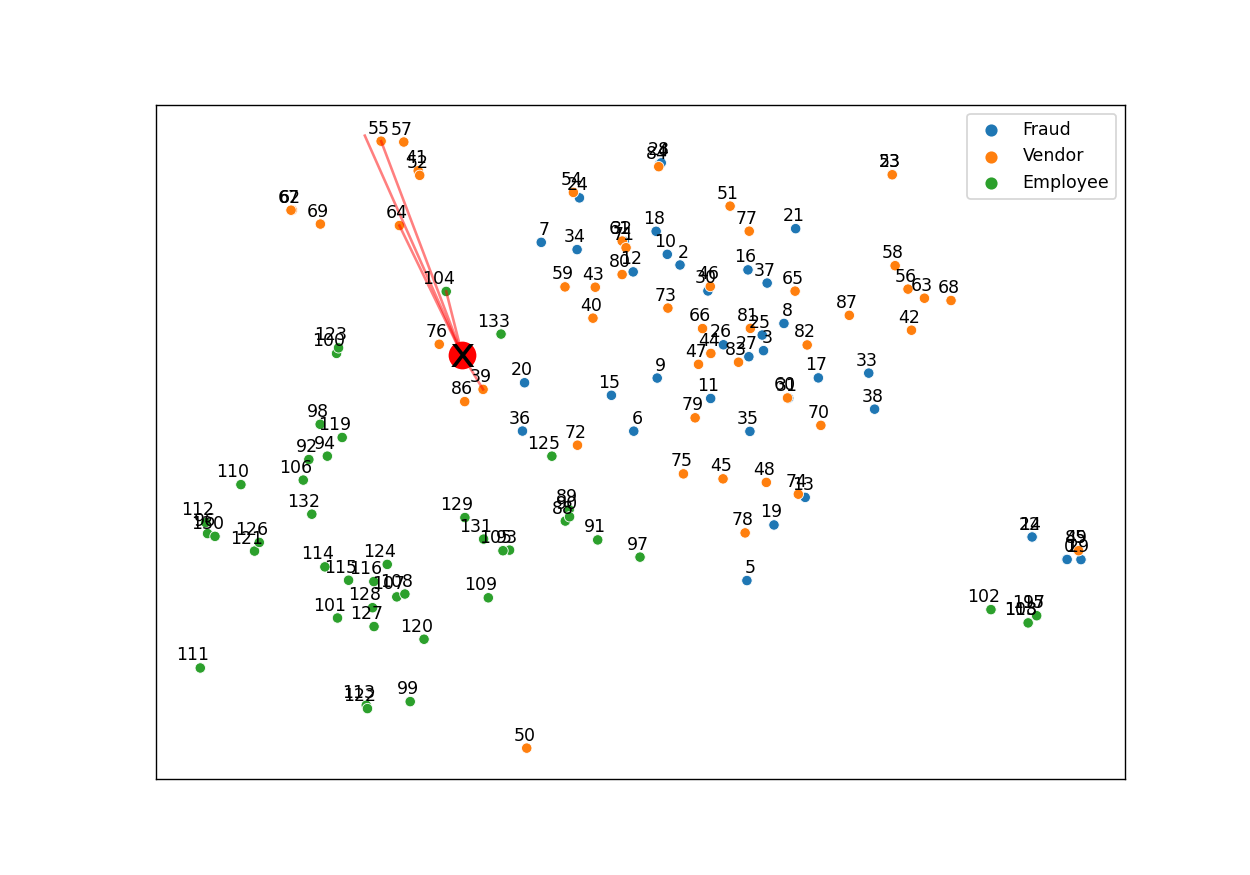

In [236]:
## create embedding Matrix
y = np.concatenate([embedding_bert(v, tokenizer, nlp) for v in dic_clusters.values()])
X = embedding_bert(txt_instance, tokenizer, nlp).mean(0).reshape(1,-1)
M = np.concatenate([y,X])

## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
M = pca.fit_transform(M)
y, X = M[:len(y)], M[len(y):]

## create dtf clusters
df = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(df) + len(v)
    df_group = pd.DataFrame(y[len(df):size], columns=["x","y"], index=v)
    df_group["cluster"] = k
    df=pd.concat([df,df_group],ignore_index=True)
#     df = df.append(df_group)

## plot clusters
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df, x="x", y="y", hue="cluster", ax=ax)
#ax.legend().texts[0].set_text(None)
ax.legend()
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
for i in range(len(df)):
    ax.annotate(df.index[i], 
               xy=(df["x"].iloc[i],df["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

## add txt_instance
ax.scatter(x=X[0][0], y=X[0][1], c="red", linewidth=10)
ax.annotate("x", xy=(X[0][0],X[0][1]), ha='center', va='center', fontsize=25)

## calculate similarity
sim_matrix = metrics.pairwise.cosine_similarity(X, y)

## add top similarity
for row in range(sim_matrix.shape[0]):
    ### sorted {keyword:score}
    dic_sim = {n:sim_matrix[row][n] for n in range(sim_matrix.shape[1])}
    dic_sim = {k:v for k,v in sorted(dic_sim.items(), key=lambda item:item[1], reverse=True)}
    ### plot lines
    for k in dict(list(dic_sim.items())[0:5]).keys():
        p1 = [X[row][0], X[row][1]]
        p2 = [y[k][0], y[k][1]]
        ax.plot([p1[0],p2[0]], [p1[1],p2[1]], c="red", alpha=0.5)
plt.show()

In [237]:
def utils_cosine_sim(a, b, nlp=None):
    '''
    Compute cosine similarity between 2 strings or 2 vectors/matrices: cosine_sim = matrix (rows_a x rows_b)
    :parameter
        :param a: string, vector, or matrix
        :param b: string, vector, or matrix
        :param nlp: gensim model - used only if a and b are strings
    :return
        cosine similarity score or matrix
    '''
    ## string vs string = score
    if (type(a) is str) or (type(b) is str):
        nlp = gensim_api.load("glove-wiki-gigaword-300") if nlp is None else nlp
        cosine_sim = nlp.similarity(a,b)
        
    else:
        ## vector vs vector = score
        if (len(a.shape) == 1) and (len(a.shape) == 1):
            a = a.reshape(1,-1)
            b = b.reshape(1,-1)
            cosine_sim = metrics.pairwise.cosine_similarity(a, b)[0][0]  #np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
        
        ## matrix vs matrix = matrix (rows_a x rows_b)
        else:
            a = a.reshape(1,-1) if len(a.shape) == 1 else a
            b = b.reshape(1,-1) if len(b.shape) == 1 else b
            cosine_sim = metrics.pairwise.cosine_similarity(a, b)
    return cosine_sim

In [240]:
def explainer_similarity_classif(tokenizer, nlp, dic_clusters, txt_instance, token_level=False, top=5, figsize=(20,10)):
    '''
    Plot a text instance into a 2d vector space and compute similarity.
    :parameter
        :param tokenizer: transformers tokenizer
        :param nlp: transformers bert
        :param dic_clusters: dict - dict - {0:lst_words, 1:lst_words, ...}
        :param txt_instance: string - raw text
        :param token_level: bool - if True the text is broken down into tokens otherwise the mean vector is taken
        :param top: num - top similarity to display
    '''
    ## create embedding Matrix
    y = np.concatenate([embedding_bert(v, tokenizer, nlp) for v in dic_clusters.values()])
    X = embedding_bert(txt_instance, tokenizer, nlp) if token_level is True else embedding_bert(txt_instance, tokenizer, nlp).mean(0).reshape(1,-1)
    M = np.concatenate([y,X])
    
    ## pca
    pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
    M = pca.fit_transform(M)
    y, X = M[:len(y)], M[len(y):]
    
    ## create dtf clusters
    df = pd.DataFrame()
    for k,v in dic_clusters.items():
        size = len(df) + len(v)
        df_group = pd.DataFrame(y[len(df):size], columns=["x","y"], index=v)
        df_group["cluster"] = k
        df=pd.concat([df,df_group],ignore_index=True)
#         df = df.append(df_group)
        
    ## plot clusters
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data=df, x="x", y="y", hue="cluster", ax=ax)
    #ax.legend().texts[0].set_text(None)
    ax.legend()
    ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
    for i in range(len(df)):
        ax.annotate(df.index[i], xy=(df["x"].iloc[i], df["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
    
    ## add txt_instance
    if token_level is True:
        # returns list of words excluding CLS and EOS tokens added during tokenization
        tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(txt_instance))[1:-1]
        # dataframe with the words as index and rows as embeddings of each word of dim 768
        df_ = pd.DataFrame(X, columns=["x","y"], index=tokens)
        # eliminate index with # (~ returns the complement)
        df_ = df_[~df_.index.str.contains("#")]
        # eliminate one letter index
        df_ = df_[df_.index.str.len() > 1]
        X = df_.values
        ax.scatter(x=df_["x"], y=df_["y"], c="red")
        for i in range(len(df_)):
            ax.annotate(df_.index[i], xy=(df_["x"].iloc[i], df_["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
    else:
        ax.scatter(x=X[0][0], y=X[0][1], c="red", linewidth=10)
        ax.annotate("x", xy=(X[0][0],X[0][1]), ha='center', va='center', fontsize=25)
    
    ## calculate similarity
    sim_matrix = utils_cosine_sim(X,y) 

    ## add top similarity
    for row in range(sim_matrix.shape[0]):
        ### sorted {keyword:score}
        dic_sim = {n:sim_matrix[row][n] for n in range(sim_matrix.shape[1])}
        dic_sim = {k:v for k,v in sorted(dic_sim.items(), key=lambda item:item[1], reverse=True)}
        ### plot lines
        for k in dict(list(dic_sim.items())[0:top]).keys():
            p1 = [X[row][0], X[row][1]]
            p2 = [y[k][0], y[k][1]]
            ax.plot([p1[0],p2[0]], [p1[1],p2[1]], c="red", alpha=0.5)
    plt.show()

['obfuscation', 'deceptions', 'blatant', 'blackmail', 'evasion', 'trickery', 'misrepresentation', 'concealment', 'concocted', 'dishonesty', 'deception', 'fraud', 'frauds', 'deceit', 'forgery', 'shameless', 'falsification', 'cover-up', 'swindle', 'manipulation', 'duplicity', 'cheat', 'subterfuge', 'dishonest', 'phony', 'imposture', 'fakery', 'scam', 'artifice', 'cheating', 'scams', 'treachery', 'gamesmanship', 'misdirection', 'chicanery', 'fraudulent', 'sham', 'manipulations', 'defraud']
['buys', 'banker', 'broker', 'auctioneer', 'shopper', 'salesperson', 'jeweler', 'purchaser', 'trader', 'appliance', 'shopkeeper', 'supplier', 'distributor', 'dealership', 'saleswoman', 'wholesale', 'buyer', 'seller', 'vendor', 'pedlar', 'sells', 'proprietor', 'wholesaler', 'merchant', 'bookseller', 'maker', 'manufacturer', 'businessperson', 'shop', 'hawker', 'peddler', 'customer', 'retailer', 'grocery', 'salesmen', 'supermarket', 'selling', 'distributors', 'grower', 'purveyor', 'entrepreneur', 'pharmaci

<IPython.core.display.Javascript object>


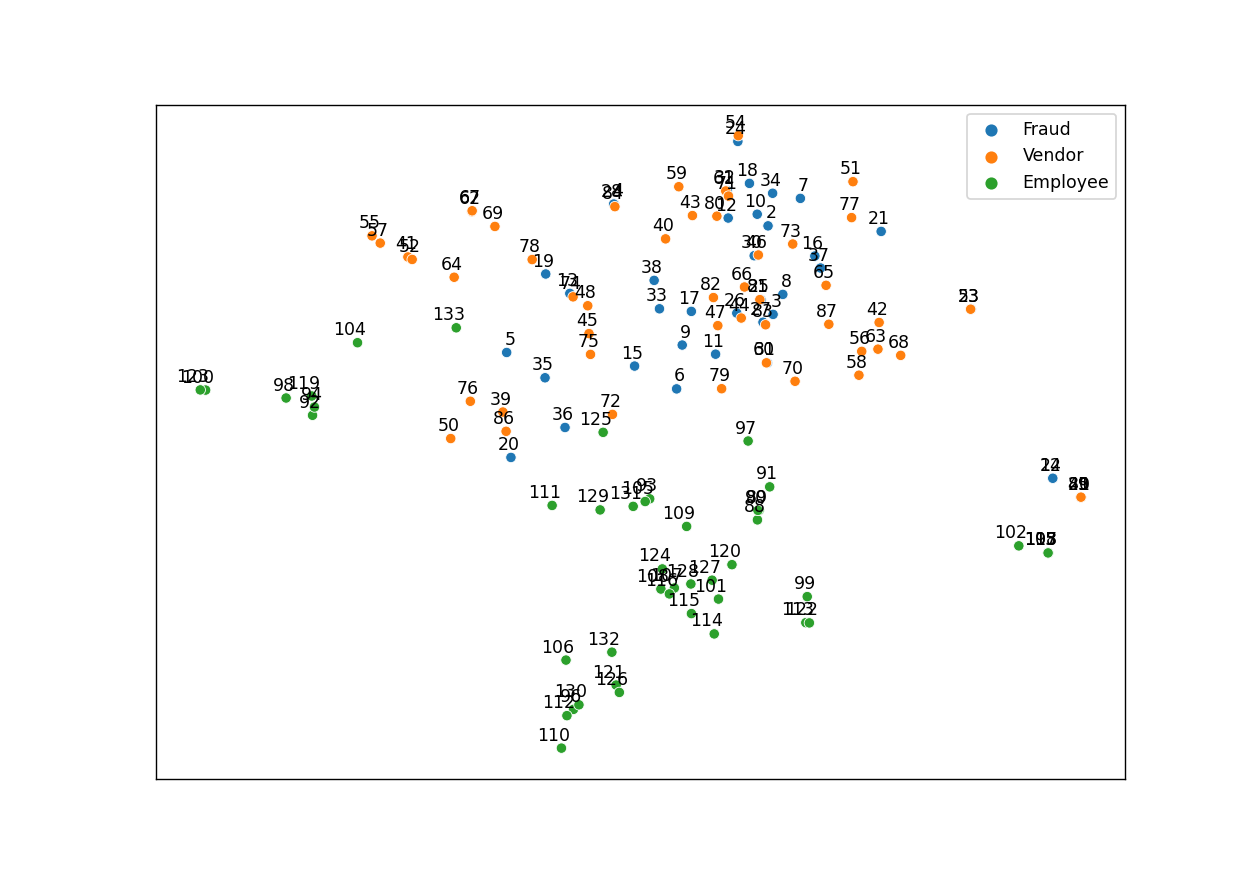

ValueError: Shape of passed values is (177, 2), indices imply (251, 2)

In [241]:
explainer_similarity_classif(tokenizer, nlp, dic_clusters, dtf["text_clean"].iloc[index], token_level=True, top=1, figsize=(10,7))

## Planning
- As we all know openAI api will analyze the meaning of entire sentence without just matching the same word in the email so therefore what we can do we can convert the unsupervised dataset into supervised dataset to train the classifier which can be about fraud, we can be business related email,which can be about meetings etc

1. Top N Similar emails with the help of queries
2. fraud classifier with the help of LSTM
3. fraud classifier with the help of BERT
4. Text clustering with the help of BERT
5. Sentiment Analysis using TextBlob, vadarSentiment
6. Emotional Analysis using NRCLex
7. We have written the code for finding the emails with unofficial domains
8. We have written the code for finding the unique and similar emails
